# Making stacked histograms
- processes an `events[year][ch][sample]` object using `make_events_dict()`
- uses `plot_hists()` to make stacked histograms

In [1]:
import glob
import os
import json
import pickle
import yaml
import math

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import sys
sys.path
sys.path.append("../python/")

import utils

plt.rcParams.update({"font.size": 20})

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# get lumi
with open("../fileset/luminosity.json") as f:
    luminosity = json.load(f)
    
luminosity

{'ele': {'Run2': 137640.0,
  '2016APV': 19492.72,
  '2016': 16809.96,
  '2017': 41476.02,
  '2018': 59816.23},
 'mu': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'lep': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96}}

In [4]:
def get_lumi(years, channels):
    lum_ = 0
    for year in years:
        lum = 0
        for ch in channels:
            lum += luminosity[ch][year] / 1000.0

        lum_ += lum / len(channels)    
    return lum_

In [5]:
def rename_column(ev_dict, old_name, new_name):
    for year in ev_dict:
        for ch in ev_dict[year]:
            for sample in ev_dict[year][ch]:
                df = ev_dict[year][ch][sample]
                df[new_name] = df[old_name]
                
                # drop old column
                df = df[df.columns.drop(list(df.filter(regex=old_name)))]

# tagger_old = "fj_ParT_score_finetuned_v2_1-12"
# tagger_new = "fj_ParT_score_finetuned_v2_1_12"
# rename_column(events_dict, tagger_old, tagger_new)                

In [41]:
 # define your regions here
presel = {
        "had": {
#             "tagger>0.5": "fj_ParT_score_finetuned>0.5",
#             "tagger>0.5": "fj_ParT_score_finetuned_v35_12_14>0.5",
            
        },
}

from make_stacked_hists_taggerSF import make_events_dict
channels = ["had"]
samples = [
    "QCD",
    "TTbar",
    "Data",
]

years = ["2016"]

In [46]:
events_dict = {}

In [47]:
! ls ../eos/mar_28_sf_small_inference_2016

JetHT_Run2016F    QCD_Pt_1400to1800 QCD_Pt_3200toInf  TTToHadronic
JetHT_Run2016G    QCD_Pt_170to300   QCD_Pt_470to600   TTToSemiLeptonic
JetHT_Run2016H    QCD_Pt_1800to2400 QCD_Pt_600to800
QCD_Pt_1000to1400 QCD_Pt_2400to3200 QCD_Pt_800to1000
QCD_Pt_120to170   QCD_Pt_300to470   TTTo2L2Nu


In [59]:
! ls ../eos/mar_28_sf_small_inference_2016/TTTo2L2Nu/outfiles/

0-5had     145-150had 195-200had 245-250had 295-300had 345-350had 70-75had
10-15had   15-20had   20-25had   25-30had   30-35had   35-40had   75-80had
100-105had 150-155had 200-205had 250-255had 300-305had 350-355had 80-85had
105-110had 155-160had 205-210had 255-260had 305-310had 355-360had 85-90had
110-115had 160-165had 210-215had 260-265had 310-315had 40-45had   90-95had
115-120had 165-170had 215-220had 265-270had 315-320had 45-50had   95-100had
120-125had 170-175had 220-225had 270-275had 320-325had 5-10had
125-130had 175-180had 225-230had 275-280had 325-330had 50-55had
130-135had 180-185had 230-235had 280-285had 330-335had 55-60had
135-140had 185-190had 235-240had 285-290had 335-340had 60-65had
140-145had 190-195had 240-245had 290-295had 340-345had 65-70had


In [48]:
samples_dir = {
    "2016":    "../eos/mar_28_sf_small_inference_2016",
}

In [49]:
events_dict = {}
for year in years:
    
    out = make_events_dict([year], channels, samples_dir[year], samples, presel, region="signal_region", keep_weights=True)
    events_dict = {**events_dict, **out}

INFO:root:Finding JetHT_Run2016H samples and should combine them under Data
INFO:root:No parquet file for JetHT_Run2016H
INFO:root:Finding JetHT_Run2016F samples and should combine them under Data
INFO:root:No parquet file for JetHT_Run2016F
INFO:root:Finding JetHT_Run2016G samples and should combine them under Data
INFO:root:No parquet file for JetHT_Run2016G
INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Will fill the TTbar dataframe with the remaining 32309 events
INFO:root:tot event weight 2826.4033203125 

INFO:root:Finding QCD_Pt_120to170 samples and should combine them under QCD
INFO:root:No parquet file for QCD_Pt_120to170
INFO:root:Finding QCD_Pt_3200toInf samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Will fill the QCD dataframe with the remaining 628 events
INFO:root:tot event weight 0.001532604917883873 

INFO:root:Finding QCD_Pt_1

In [63]:
events_dict["2016"]["had"]["QCD"]

,METpt,METphi,"dR(lep, lep_fatjet)",fj_isTop,fj_isTop_Matched,fj_Top_numMatched,fj_isTop_W_lep_b,fj_isTop_W_lep,fj_isTop_W_ele_b,fj_isTop_W_ele,...,had_subjetEta,had_subjetPhi,had_subjetMass,had_subjetBscore,weight_had,fj_ParT_score,fj_ParT_mass,event_weight,fj_ParT_score_finetuned,fj_ParT_score_finetuned_v35_12_14
0,179.086609,-0.801270,NaN,True,False,0,0,0,0,0,...,0.184021,-0.543335,42.718750,0.247437,1.0,0.0,NaN,0.000002,NaN,NaN
1,139.883469,0.750000,NaN,True,False,0,0,0,0,0,...,-0.186981,-2.599121,14.437500,0.418213,1.0,0.0,NaN,0.000002,NaN,NaN
2,73.230629,-3.134277,NaN,True,False,0,0,0,0,0,...,0.367371,-0.275757,60.437500,0.142944,1.0,0.0,NaN,0.000002,NaN,NaN
3,110.883858,-2.796387,NaN,True,False,0,0,0,0,0,...,-0.116898,0.207947,9.203125,0.583496,1.0,0.0,NaN,0.000002,NaN,NaN
4,377.715637,0.950439,NaN,True,False,0,0,0,0,0,...,0.314209,-2.071777,66.500000,0.194336,1.0,0.0,NaN,0.000002,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,265.763580,-2.642578,NaN,True,False,0,0,0,0,0,...,-0.096085,0.566528,18.359375,0.150146,1.0,0.0,NaN,0.009370,NaN,NaN
332,32.504246,1.671143,NaN,True,False,0,0,0,0,0,...,0.983765,-1.369141,111.250000,0.213501,1.0,0.0,NaN,0.009370,NaN,NaN
333,116.692429,-2.299805,NaN,True,False,0,0,0,0,0,...,-0.363647,1.015625,24.921875,0.191528,1.0,0.0,NaN,0.009370,NaN,NaN
334,267.705170,-0.897705,NaN,True,False,0,0,0,0,0,...,0.197540,2.385742,23.875000,0.550781,1.0,0.0,NaN,0.009370,NaN,NaN


# Stacked hists

In [64]:
def fix_neg_yields(h):
    """
    Will set the bin yields of a process to 0 if the nominal yield is negative, and will
    set the yield to 0 for the full Systematic axis.
    """
    for sample in h.axes["samples"]:
        neg_bins = np.where(h[{"samples": sample}].values() < 0)[0]

        if len(neg_bins) > 0:
            print(f"{sample}, has {len(neg_bins)} bins with negative yield.. will set them to 0")

            sample_index = np.argmax(np.array(h.axes["samples"]) == sample)

            for neg_bin in neg_bins:
                h.view(flow=True)[sample_index, neg_bin + 1] = 0

In [65]:
vars_to_plot = [
#     "fj_msoftdrop",        
#     "rec_W_lnu_m",
#     "fj_pt",
#     "lep_pt",
#     "lep_eta",
    
#     "lep_fj_dr",
#     "lep_met_mt",
#     "met_fj_dphi",
#     "met_pt",    
    
#     "btag_1a",
#     "0btag_1b",
#     "1pbtag_1b",
    
#     "0btagT_btagSF",
#     "1plusbtagT_btagSF"
    
#     "rec_higgs_etajet_m",
#     "fj_ParT_mass",
#     "fj_ParT_score_finetuned"
    
    "rec_higgs_m",    
    # AN
#     "FirstFatjet_pt",
#     "SecondFatjet_pt",
#     "fj_pt",
#     "lep_pt",
#     "NumFatjets",
#     "NumOtherJets",
#     "lep_fj_dr",
#     "met_pt",
#     "met_fj_dphi",
#     "lep_met_mt",    
#     "ht",
#     "fj_mass",
#     "rec_W_qq_m",
#     "rec_W_lnu_m",    
#     "fj_lsf3",
    
#     "lep_isolation",
#     "lep_isolation_ele",
#     "lep_isolation_ele_highpt",
#     "lep_isolation_ele_lowpt",
    
#     "lep_isolation_mu",
#     "lep_isolation_mu_highpt",
#     "lep_isolation_mu_lowpt",   
    
#     "lep_misolation",
#     "lep_misolation_highpt",
#     "lep_misolation_lowpt",    
]

samples_to_plot = [
    "ggF", 
    "VBF",
#     "ttH",
#     "WH",
#     "ZH",    
    "QCD",
    "WJetsLNu",
#     "WJetsLNu_unmatched",
#     "WJetsLNu_matched",
    "TTbar",
    "SingleTop",
    "Diboson",
    "EWKvjets",
    "Data",
    
#     "DYJets",
#     "WZQQ",
    "WZQQorDYJets",    
]

# samples_to_plot = ["QCD"]

In [211]:
# tagger = "fj_ParT_score"
# tagger = "fj_ParT_score_finetuned"

tagger = "fj_ParT_score_finetuned_v35_12_14"
tagger_cut = 0.915   # VBF
# tagger_cut = 0.924  # ggF

presel = {
#     "Pre-selection": f"fj_pt>0",   # dummy
    
    "SR": f"{tagger}>{tagger_cut} & (n_bjets_T==0)",
    
#     "Pre-selection": f"({tagger}>0.75)",   # dummy    
    
#     "Pre-selection": f"met_pt>100 & ({tagger}<0.5) & n_bjets_T>0",   # dummy    
#     "Pre-selection": f"met_pt>100 & n_bjets_T>0",   # dummy    

#     "Pre-selection": f"met_pt>100 & n_bjets_L==0 & {tagger}>0.5 & {tagger}<0.97",   # dummy    
    
#     "Pre-selection": f"met_pt>20",

#     "SR": f"({tagger}>0.98) & (n_bjets_T==0)",    
    
#     "SR2": f"({tagger}>0.97) & ({tagger}<0.98) & (n_bjets_T==0)",
#     "WJets CR": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0)",
    
#     "WJets CR": f"({tagger}<0.88) & ({tagger}>0.750) & (n_bjets_T==0) & (met_pt>100)",
#     "Top CR": f"({tagger}>0.75) & (n_bjets_T>0)",
}

categories_sel = {
    "VBF": f"( ({tagger}>{tagger_cut}) & (n_bjets_T==0) ) & ( (mjj>1000) & (deta>3.5) )",
#     rf"ggF": "(mjj<1000) | (deta<3.5)",
        
#     r"ggF pT [250, 300]": f"( ({tagger}>{tagger_cut}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (fj_pt>250) & (fj_pt<300) )",
#     f"ggF pT [300, 450]": f"( ({tagger}>{tagger_cut}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (fj_pt>300) & (fj_pt<450) )",
#     r"ggF pT [450, Inf]": f"( ({tagger}>{tagger_cut}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (fj_pt>450) )",
}

channels = ["ele", "mu"]
# channels = ["mu"]
years = ["2018", "2017", "2016", "2016APV"]
# years = ["2018"]

num, den = 0, 0
threshold = 0

# fill histograms
hists = {}

# ev = events_dict["new_correctionsNOTAGGER"]

ev = events_dict["wjetsHT"]
# ev = events_dict["wjetsNLO"]

# ev = events_dict["new_correctionsNODPHI"]

MET_cut = False
import utilsAN

massbin = 20
for var in vars_to_plot:

    if var == "rec_higgs_m":
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="samples", growth=True),
            hist2.axis.Variable(list(range(45, 210, massbin)), name="var", label=r"Higgs reconstructed mass [GeV]", overflow=True)
        )    
    elif var == "fj_ParT_mass":
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="samples", growth=True),
            hist2.axis.Variable(list(range(45, 210, massbin)), name="var", label=r"ParT regressed mass [GeV]", overflow=True)
        )              
    else:
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="samples", growth=True),
            utilsAN.axis_dict[var],
#             hist2.axis.Regular(50, 0, 1, name="var", label=r"tagger", overflow=True)
            
        )        
        
    for sample in samples_to_plot:
        for year in years:
            for ch in channels:
            
                region, sel = list(presel.items())[0]
                
#                 if sample == "WZQQ":
#                     continue  
#                 if sample == "DYJets":
#                     df = ev[year][ch][sample]
#                     df = pd.concat([df, ev[year][ch]["WZQQ"]])
#                 else:
#                     df = ev[year][ch][sample]


#                 if "WJetsLNu" in sample:
#                     df = ev[year][ch]["WJetsLNu"]
                    
#                     if "unmatched" in sample:
#                         df = df[df["fj_V_isMatched"]!=1]
#                     else:
#                         df = df[df["fj_V_isMatched"]==1]
                
#                 else:
#                     df = ev[year][ch][sample]
        
                df = ev[year][ch][sample]
                
                df = df.query(sel)
                    
                if "MET>X" in region:
                    MET_cut = 100
                    df = df[df["met_pt"]>MET_cut]
                                
                if len(categories_sel)>=1:
                    category, category_sel = list(categories_sel.items())[0]
                    df = df.query(category_sel)
            
#                 if sample == "QCD":
#                     threshold = 100
#                     den += len(df['event_weight'])
#                     num += sum(df["event_weight"]>threshold)

#                     df = df[df["event_weight"] < threshold]
                
                
                if "lep_isolation_ele" in var:
                    if ch=="ele":
                        
                        if "highpt" in var:
                            df = df[(df["lep_pt"]>120)]
                        elif "lowpt" in var:
                            df = df[(df["lep_pt"]<120)]                            

                        x = df["lep_isolation"]
                    else:
                        continue
                        
                elif "lep_isolation_mu" in var:
                    if ch=="mu":
                        
                        if "highpt" in var:
                            df = df[(df["lep_pt"]>55)]
                        elif "lowpt" in var:
                            df = df[(df["lep_pt"]<55)] 

                        x = df["lep_isolation"]

                    else:
                        continue
                    
                elif "lep_misolation" in var:
                    if ch == "mu":
                        if "highpt" in var:
                            df = df[(df["lep_pt"]>55)]
                        elif "lowpt" in var:
                            df = df[(df["lep_pt"]<55)] 

                        x = df["lep_misolation"]
                        
                    else:
                        continue

                else:
                    x = df[var]
                    
#                 if var == "lep_eta":
#                     x = np.absolute(df[var])
                
#                 df = df[np.absolute(df["lep_eta"])<0.5]
#                 x = df[var]
                
                w = df["event_weight"]
                
#                 if sample != "Data":
# #                     w *= df["btag_1a"]
#                     w *= df["0btag_1b"]
# #                     w *= df["1pbtag_1b"]

#                 if sample != "Data":
#                     w *= 0.989
#                     w *= 0.919

                hists[var].fill(
                    samples=sample,
                    var=x,
                    weight=w,
                )     
try:
    print(f"Removing {num} out of {den} qcd events by applying event_weight<{threshold} ({(100*num/den):.2f}%)")
except:
    z=1
    
for var in vars_to_plot:
    fix_neg_yields(hists[var])

Will plot rec_higgs_m histogram
SR (RUN2):
Category: VBF
------------------------
s/sqrt(b) in [100,150]: 1.43
------------------------
Signal: 12.15
- ggF: 22%
- VBF: 78%
------------------------
Background: 70.74
- QCD: 0%
- WZQQorDYJets: 6%
- Others: 9%
- TTbar: 32%
- WJetsLNu: 54%


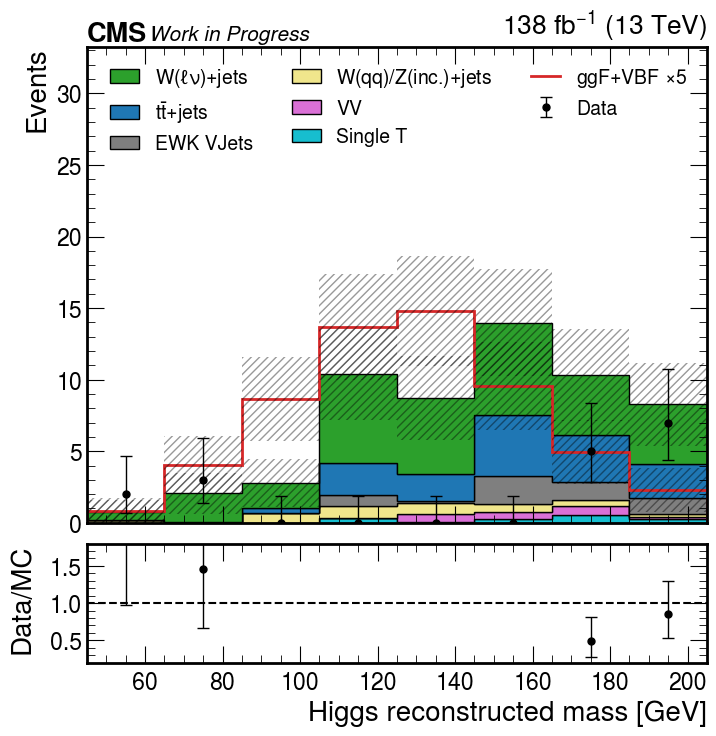

In [212]:
plt.rcParams.update({"font.size": 20})
add_data = True

if "SR" in region or ("Signal region") in region:
    add_soverb=True
    blind_region=[90,160]
    if "SR1" in region:
        mult=5
    else:
        mult=10
else:
    add_soverb=True
    blind_region=False
    mult=1
    
if "CR" in region:
    blind_region = False
    mult = 1

    
if "VBF" in categories_sel:
    mult = 5
    
from utils import plot_hists
if len(years) > 1:
    from utilsF import plot_hists
    PATH = f"/Users/fmokhtar/Desktop/AN_2024/preselection_Run2/"
#     PATH = f"/Users/fmokhtar/Desktop/AN_2024/WJetsCR/"
#     PATH = f"/Users/fmokhtar/Desktop/AN_2024/TopCR/"

#     PATH = f"/Users/fmokhtar/Desktop/AN_2024/sig_region_{list(categories_sel.keys())[0]}_Run2/"
else:
    from utilsAN import plot_hists
    PATH = f"/Users/fmokhtar/Desktop/AN_2024/preselection_{years[0]}/"
#     PATH = f"/Users/fmokhtar/Desktop/AN_2024/sig_region_{list(categories_sel.keys())[0]}_{years[0]}/"

PATH = f"/Users/fmokhtar/Desktop/AN_2024/lol/"
# from utilsF import plot_hists

if not os.path.exists(PATH):
    # Create the directory
    os.makedirs(PATH)    

plot_hists(hists, years, channels, vars_to_plot,             
            add_data=add_data,
            logy=False,
            add_soverb=add_soverb,
            only_sig=False,
            mult=mult,
            outpath=PATH,
            text_=region,
#             text_=region + f"\n {list(categories_sel.keys())[0]} category",
#             text_=region + f"\n category: {list(categories_sel.keys())[0]} \n Applying qcd event_weight<{threshold}",
#             text_=region + f"\n Applying qcd event_weight<{threshold}",

            blind_region=blind_region,
#            save_as=f"{years[0]}_{channels[0]}"
#            save_as=f"{ch}"
           
          )
# print()
get_soverb(ev, tagger, presel, categories_sel, years, channels, threshold=threshold, MET_cut=MET_cut)

In [208]:
hists["rec_higgs_m"][{"samples": "Data"}].values()[0:2]

array([1., 8.])

In [98]:
(1.21**2 + 0.83**2)**0.5

1.467310464761974

In [ ]:
dominant_backgrounds = ["WJetsLNu", "TTbar", "QCD", "WZQQorDYJets"]
def get_soverb(ev, tagger, presel, categories_sel, years, channels, MET_cut=False, misocut=None, threshold=None):

    mass_window = [100, 150]

    num_sig = {
        "ggF": 0, 
#         "ttH": 0, 
#         "VH": 0,
        "VBF": 0,
    }
    num_bkg = {
        "WJetsLNu": 0, 
        "TTbar": 0, 
        "QCD": 0,
        "WZQQorDYJets": 0,
        "Others": 0,
    }

    deno_sig, deno_bkg = 0, 0
    s, b = 0, 0

    samples = [
        "ggF", 
        "VBF",
        "ttH",
        "WH",
        "ZH",        
        "QCD",
#         "DYJets",
        "WJetsLNu",
#         "WZQQ",
        "TTbar",
        "SingleTop",
        "Diboson",
        "Data",
        "WZQQorDYJets"
    ]

    for year in years:
        for ch in channels:
            for sample in samples:
                if sample=="Data":
                    continue

                region, sel = list(presel.items())[0]

                df = ev[year][ch][sample]

                df = df.query(sel)  

                for category, category_sel in categories_sel.items():
                    df = df.query(category_sel)

                if MET_cut:
                    df = df[df["met_pt"]>MET_cut]
                    
                if threshold:
                    if sample == "QCD":
                        df = df[df["event_weight"] < threshold]
    
                ######################## composition start
                if sample in utils.signals:

                    deno_sig += df["event_weight"].sum()
                    num_sig[sample] += df["event_weight"].sum()
                else:
                    deno_bkg += df["event_weight"].sum()

                    if sample in dominant_backgrounds:
                        num_bkg[sample] += df["event_weight"].sum()
                    else:
                        num_bkg["Others"] += df["event_weight"].sum()     
                ######################## composition end

                ######################## soverb start
                df = df[(df["rec_higgs_m"]>=mass_window[0]) & (df["rec_higgs_m"]<=mass_window[1])]

                if sample in utils.signals:                
                    s += df["event_weight"].sum()
                else:
                    b += df["event_weight"].sum()
                ######################## soverb end

    num_sig = dict(sorted(num_sig.items(), key=lambda item: item[1]))
    num_bkg = dict(sorted(num_bkg.items(), key=lambda item: item[1]))

    if len(years) == 4:
        lab = "RUN2"
    else:
        lab = "_".join(years)

    print("\033[1m" + f"{list(presel.keys())[0]} ({lab}):" + '\033[0m')
    if len(list(categories_sel.items()))!=0:
        print("Category:", list(categories_sel.keys())[0])

    print("------------------------")

    if "SR" in list(presel.keys())[0]:
        print("\033[1m" + rf"s/sqrt(b) in [{mass_window[0]},{mass_window[1]}]: {s/math.sqrt(b):.2f}" + '\033[0m')
        print("------------------------")

    print(f"Signal: {deno_sig:.2f}")
    for sample in num_sig:
        print(f"- {sample}: {100*(num_sig[sample]/deno_sig):.0f}%")

    print("------------------------")
    print(f"Background: {deno_bkg:.2f}")
    for sample in num_bkg:
        if sample=="":
            print("\033[1m" + f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.0f}%")
        else:
            print(f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.0f}%")             

In [15]:
samples_to_plot = [
    "ggF", 
    "VBF",
#     "ttH",
#     "WH",
#     "ZH",    
    "QCD",
    "WJetsLNu",
#     "WJetsLNu_unmatched",
#     "WJetsLNu_matched",
    "TTbar",
    "SingleTop",
    "Diboson",
    "EWKvjets",
    
#     "DYJets",
#     "WZQQ",
    "WZQQorDYJets",    
]

In [12]:
df = events_dict["wjetsHT"][year][ch][sample]

In [13]:
for key in df:
    print(key)

lep_pt
lep_eta
lep_isolation
lep_misolation
lep_fj_dr
lep_met_mt
met_fj_dphi
met_pt
deta
mjj
ht
n_bjets_L
n_bjets_M
n_bjets_T
fj_lsf3
NumFatjets
NumOtherJets
FirstFatjet_pt
FirstFatjet_eta
FirstFatjet_phi
FirstFatjet_msd
SecondFatjet_pt
SecondFatjet_eta
SecondFatjet_phi
SecondFatjet_msd
fj_pt
fj_eta
fj_phi
fj_mass
fj_ptJES_up
fj_ptJES_down
fj_ptJER_up
fj_ptJER_down
fj_massJMS_down
fj_massJMS_up
fj_massJMR_down
fj_massJMR_up
mjjJES_up
mjjJES_down
mjjJER_up
mjjJER_down
rec_higgs_mUES_up
rec_higgs_ptUES_up
rec_higgs_mUES_down
rec_higgs_ptUES_down
rec_higgs_m
rec_higgs_pt
rec_W_qq_m
rec_W_qq_pt
rec_W_lnu_m
rec_W_lnu_pt
rec_higgs_mJES_up
rec_higgs_ptJES_up
rec_higgs_mJES_down
rec_higgs_ptJES_down
rec_higgs_mJER_up
rec_higgs_ptJER_up
rec_higgs_mJER_down
rec_higgs_ptJER_down
rec_higgs_mJMS_down
rec_higgs_ptJMS_down
rec_higgs_mJMS_up
rec_higgs_ptJMS_up
rec_higgs_mJMR_down
rec_higgs_ptJMR_down
rec_higgs_mJMR_up
rec_higgs_ptJMR_up
fj_genH_pt
fj_genH_jet
fj_genV_dR
fj_genVstar
genV_genVstar_dR
fj

In [21]:
df[f"weight_{ch}_pileupDown"]

0       0.374207
3       0.448128
4       0.466123
5       0.494138
7       0.425063
          ...   
4515    0.444054
4516    0.511400
4519    0.509061
4520    0.478418
4522    0.485536
Name: weight_ele_pileupDown, Length: 3013, dtype: float64

[         lep_pt   lep_eta  lep_isolation  lep_misolation  lep_fj_dr  \
 7     95.010567  0.848755       0.000000        0.000000   0.283307   
 15   214.748367 -0.671631       0.314352        0.025195   0.056688   
 35   323.078491 -0.003099       0.567439        0.000000   0.107158   
 40   504.274475  1.346436       0.000877        0.000000   0.046901   
 106  166.890060 -0.802002       0.126246        0.000000   0.125398   
 ..          ...       ...            ...             ...        ...   
 10   142.544006  0.889038       0.564684        0.424322   0.058275   
 11    86.249290 -1.971191       0.049802        0.042782   0.194567   
 15   101.901672 -1.414795       0.069848        0.000000   0.313566   
 30    38.254288  1.572998       0.018783        0.000000   0.591336   
 31    70.601151 -1.589355       0.005567        0.000000   0.434342   
 
      lep_met_mt  met_fj_dphi      met_pt      deta          mjj  ...  \
 7     33.846256     0.405415  509.738251  2.577103  1145.164

In [46]:

for key in df:
    print(key)

lep_pt
lep_eta
lep_isolation
lep_misolation
lep_fj_dr
lep_met_mt
met_fj_dphi
met_pt
deta
mjj
ht
n_bjets_L
n_bjets_M
n_bjets_T
fj_lsf3
NumFatjets
NumOtherJets
FirstFatjet_pt
FirstFatjet_eta
FirstFatjet_phi
FirstFatjet_msd
SecondFatjet_pt
SecondFatjet_eta
SecondFatjet_phi
SecondFatjet_msd
fj_pt
fj_eta
fj_phi
fj_mass
fj_ptJES_up
fj_ptJES_down
fj_ptJER_up
fj_ptJER_down
fj_massJMS_down
fj_massJMS_up
fj_massJMR_down
fj_massJMR_up
mjjJES_up
mjjJES_down
mjjJER_up
mjjJER_down
rec_higgs_mUES_up
rec_higgs_ptUES_up
rec_higgs_mUES_down
rec_higgs_ptUES_down
rec_higgs_m
rec_higgs_pt
rec_W_qq_m
rec_W_qq_pt
rec_W_lnu_m
rec_W_lnu_pt
rec_higgs_mJES_up
rec_higgs_ptJES_up
rec_higgs_mJES_down
rec_higgs_ptJES_down
rec_higgs_mJER_up
rec_higgs_ptJER_up
rec_higgs_mJER_down
rec_higgs_ptJER_down
rec_higgs_mJMS_down
rec_higgs_ptJMS_down
rec_higgs_mJMS_up
rec_higgs_ptJMS_up
rec_higgs_mJMR_down
rec_higgs_ptJMR_down
rec_higgs_mJMR_up
rec_higgs_ptJMR_up
gen_V_pt
fj_V_pt
fj_isV
fj_nprongs
fj_lepinprongs
fj_ncquarks
fj_

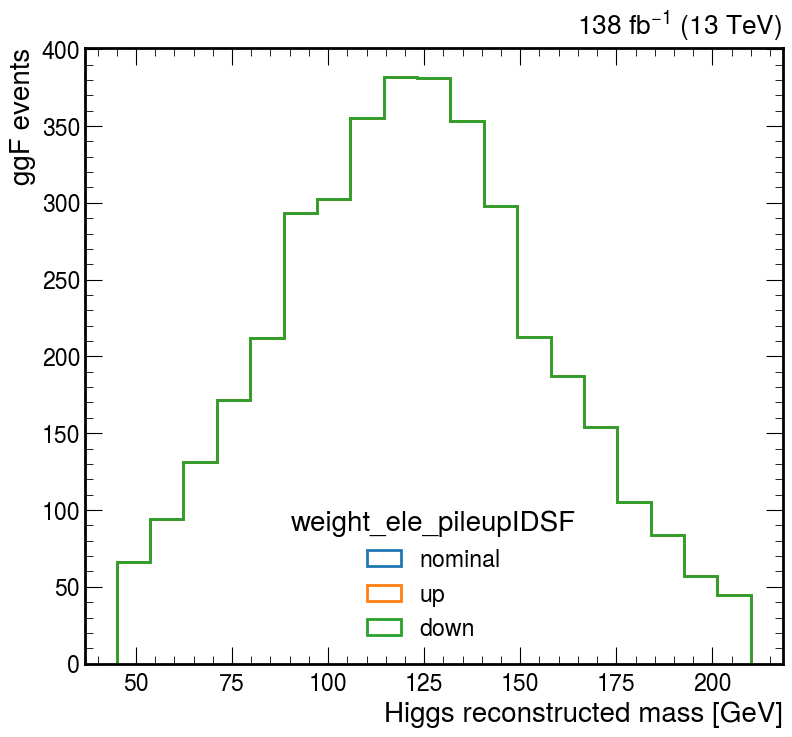

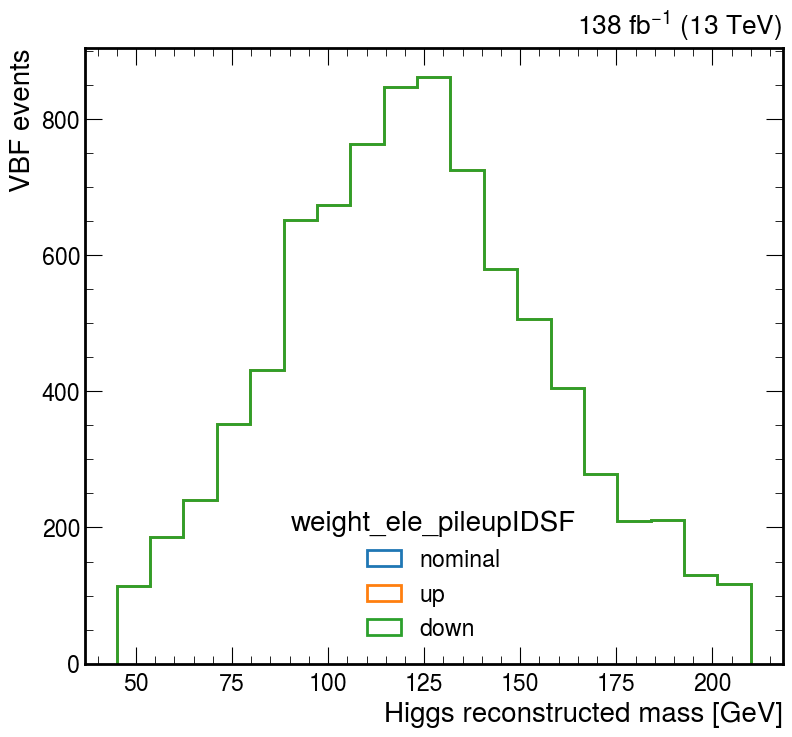

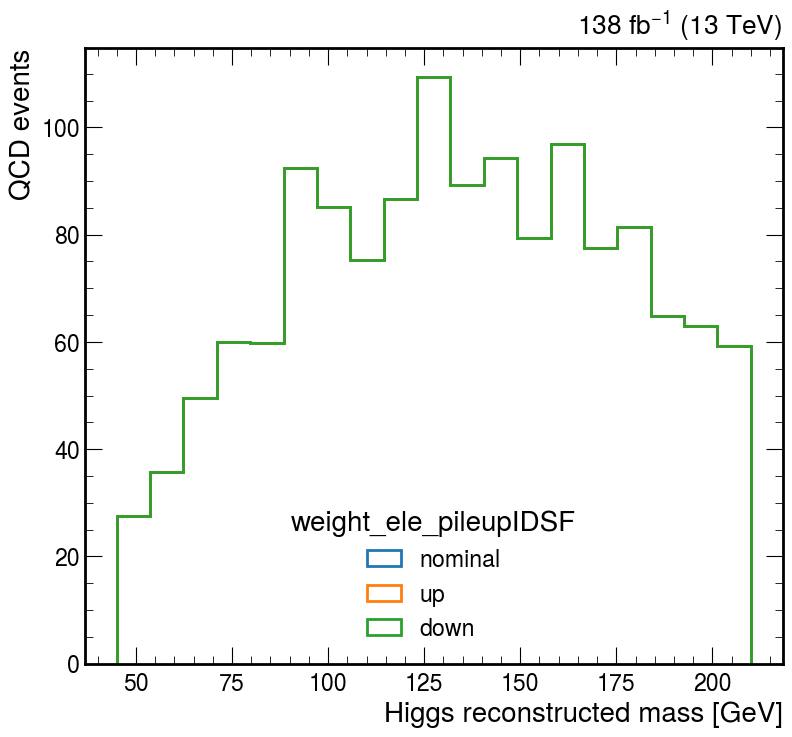

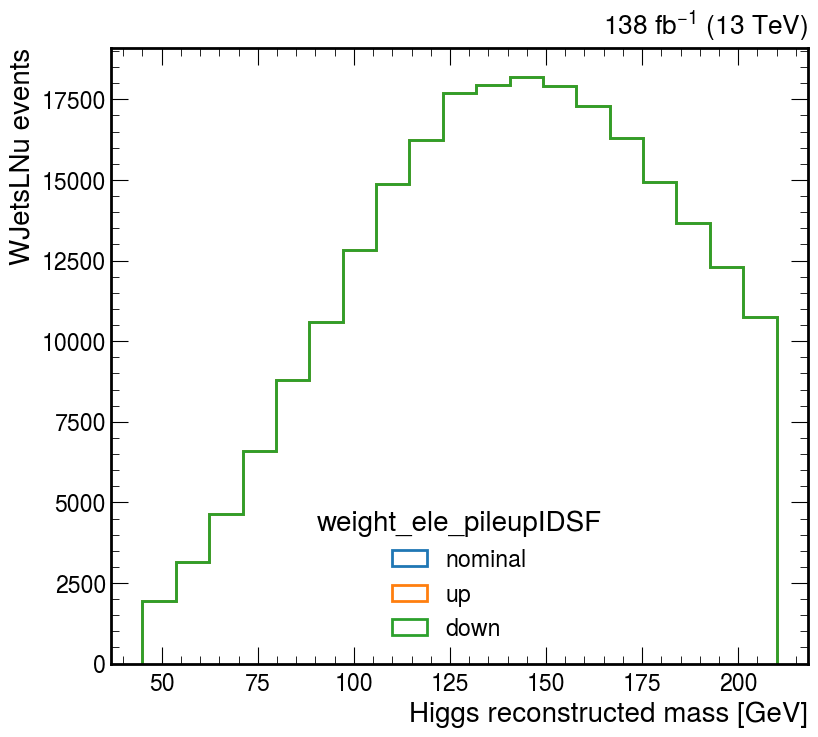

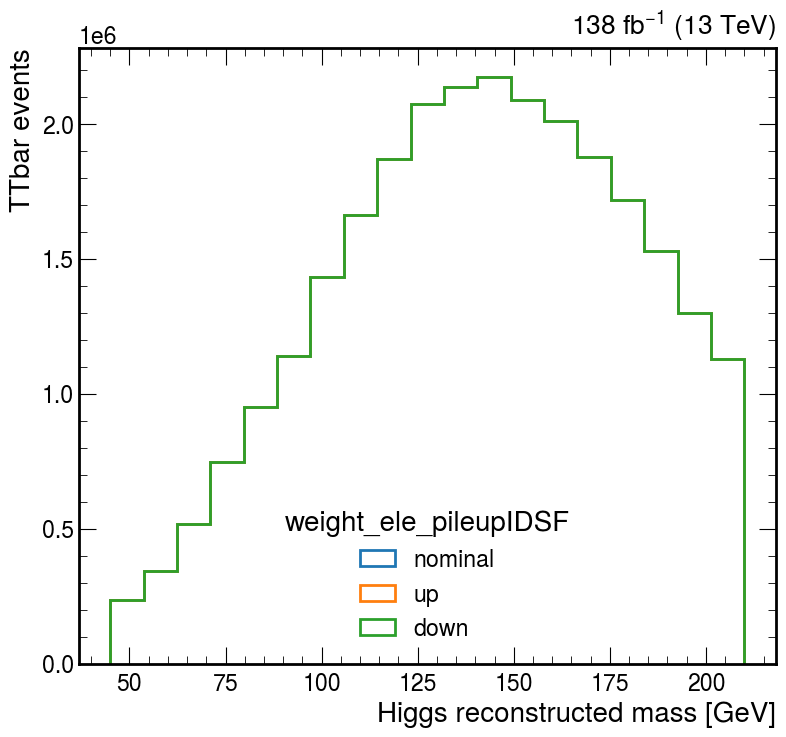

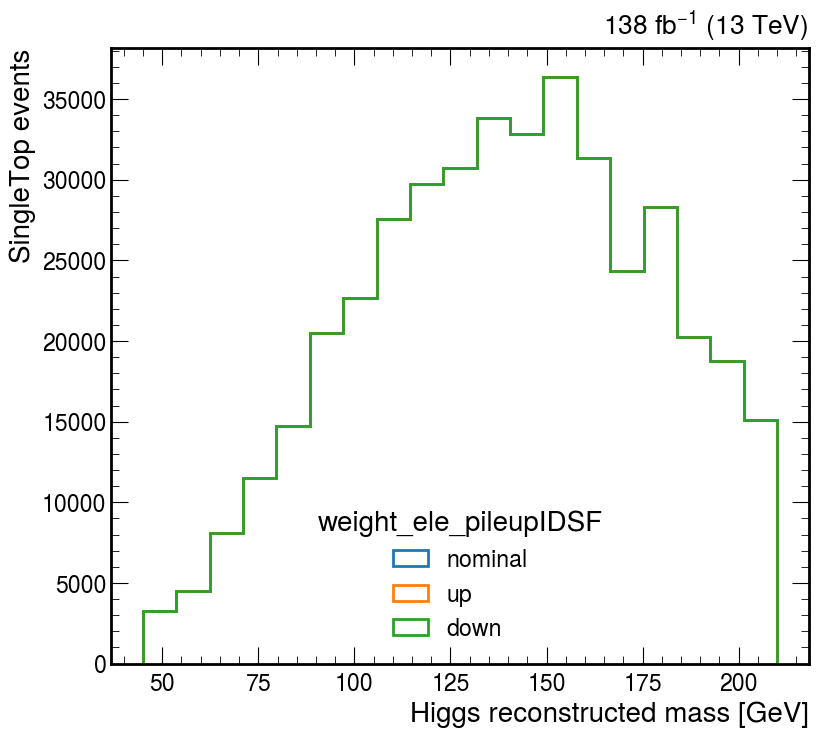

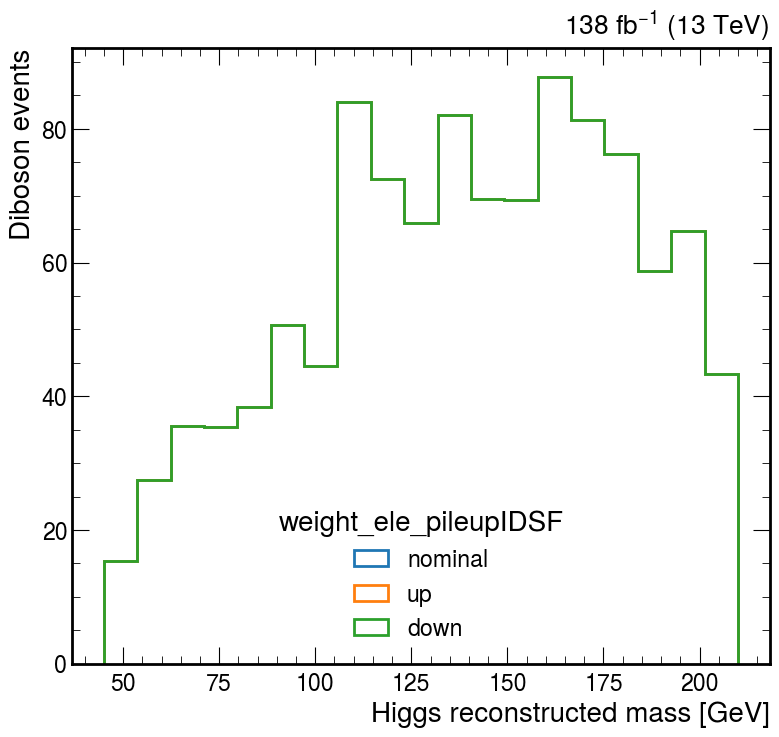

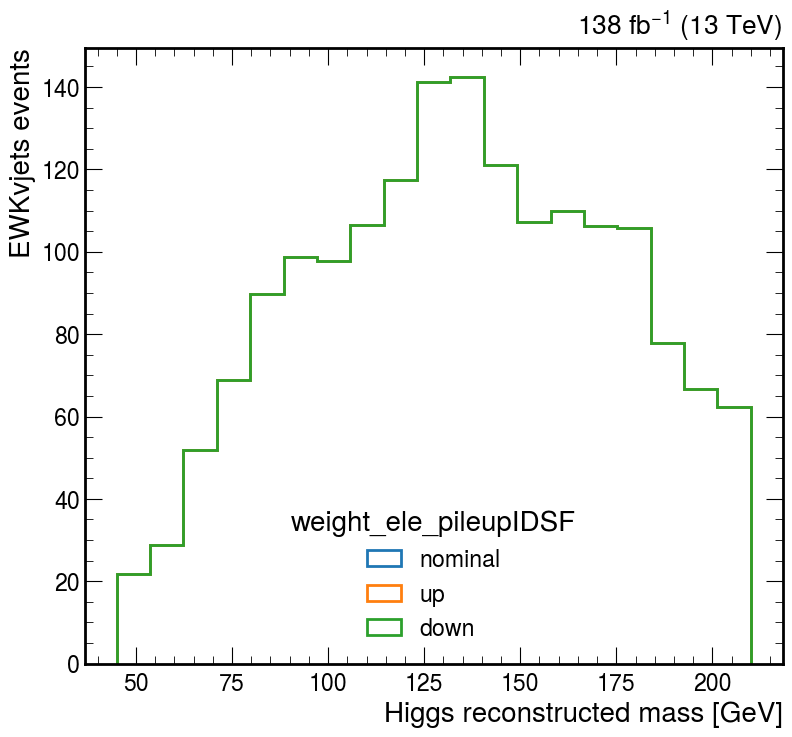

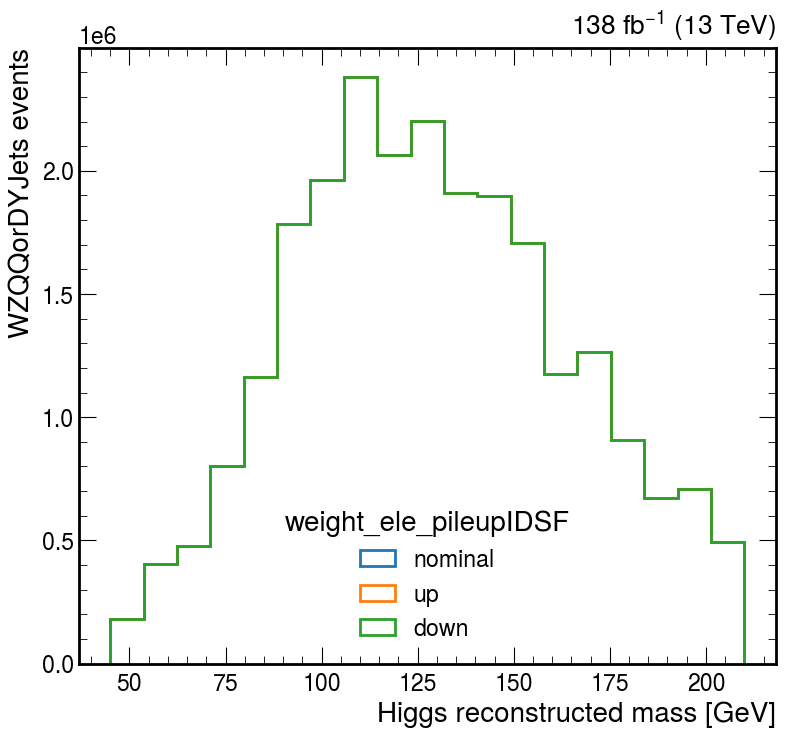

In [50]:
years = ["2018", "2017", "2016", "2016APV"]
ch = "ele"

for sample in samples_to_plot:
    
    df = pd.concat([events_dict["wjetsHT"][yr][ch][sample] for yr in years])

    fig, ax = plt.subplots(figsize=(9,8))

    bins = np.linspace(45,210,20)

    syst = f"weight_{ch}_pileupIDSF"

    ax.hist(df["rec_higgs_m"], label="nominal", weights=df[f"weight_{ch}"],
            bins=bins, lw=2, histtype="step", 
           )    
    
    ax.hist(df["rec_higgs_m"], label="up", weights=df[f"{syst}Up"],
            bins=bins, lw=2, histtype="step", 
           )

    ax.hist(df[f"rec_higgs_m"], label="down", weights=df[f"{syst}Down"],
            bins=bins, lw=2, histtype="step", 
           )

    ax.legend(title=syst)
    ax.set_xlabel("Higgs reconstructed mass [GeV]")
    ax.set_ylabel(f"{sample} events")
    hep.cms.lumitext("%.0f " % get_lumi(years, [ch]) + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)   
    
    
    if len(years)>1:
        plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/pileupIDSF/Run2_{ch}_{sample}.pdf")
        
    else:
        plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/pileupIDSF/{year}_{ch}_{sample}.pdf")
#     break

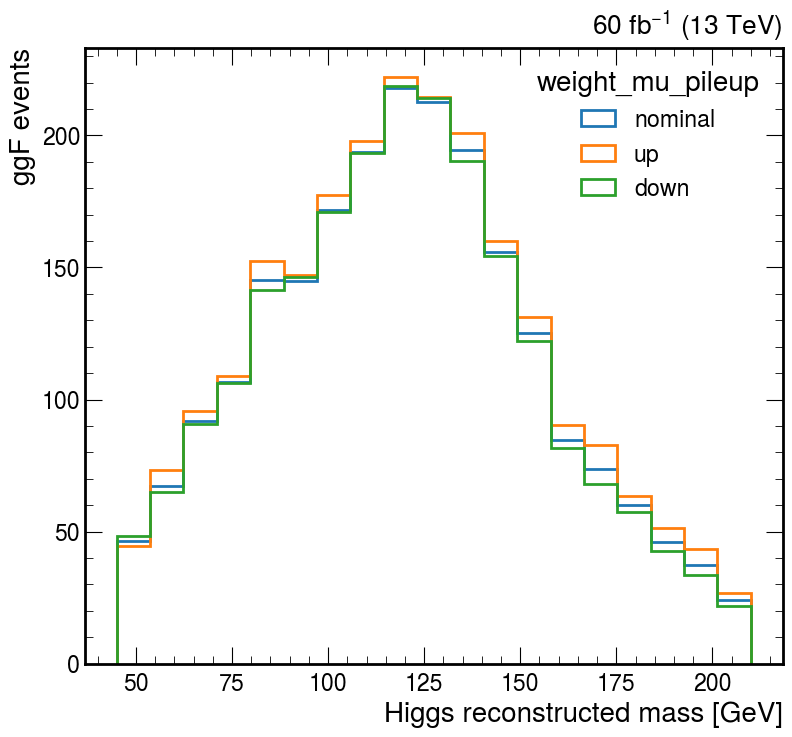

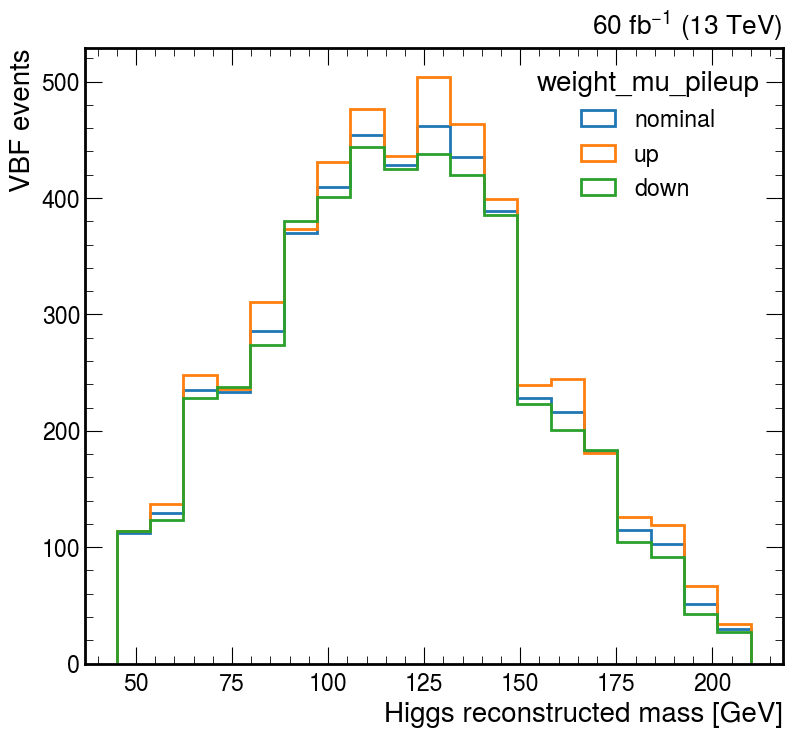

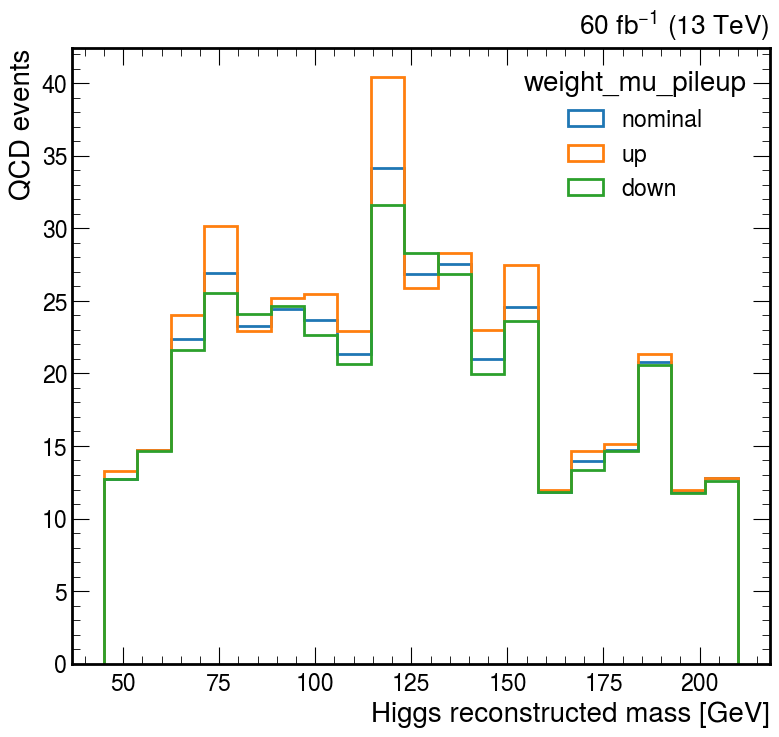

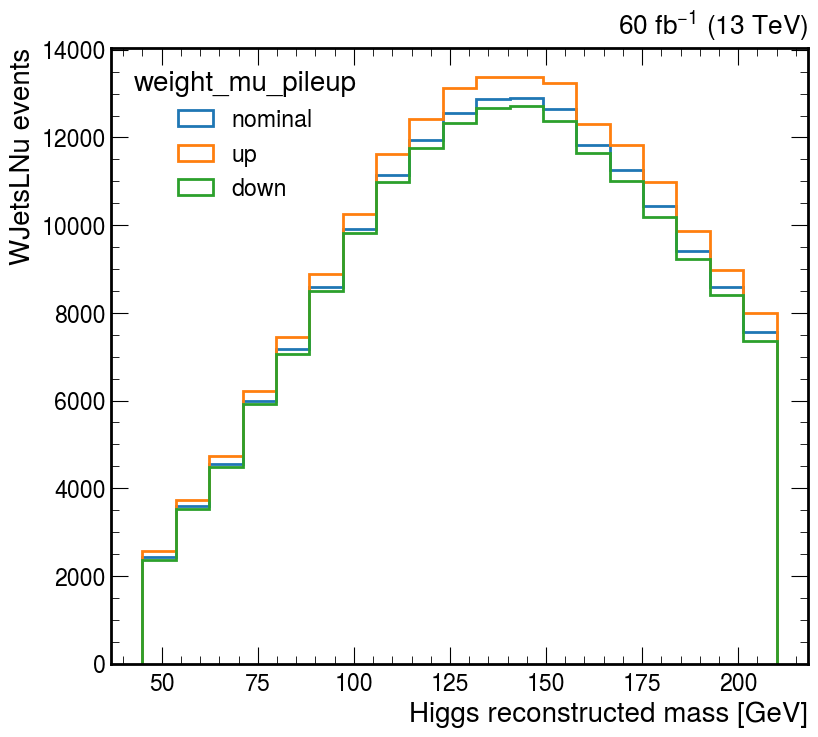

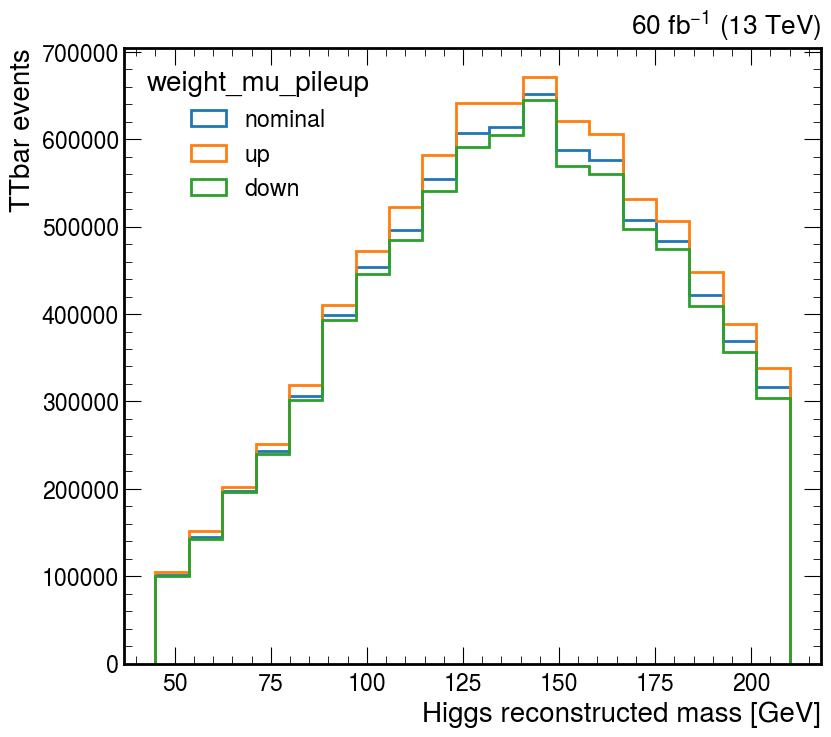

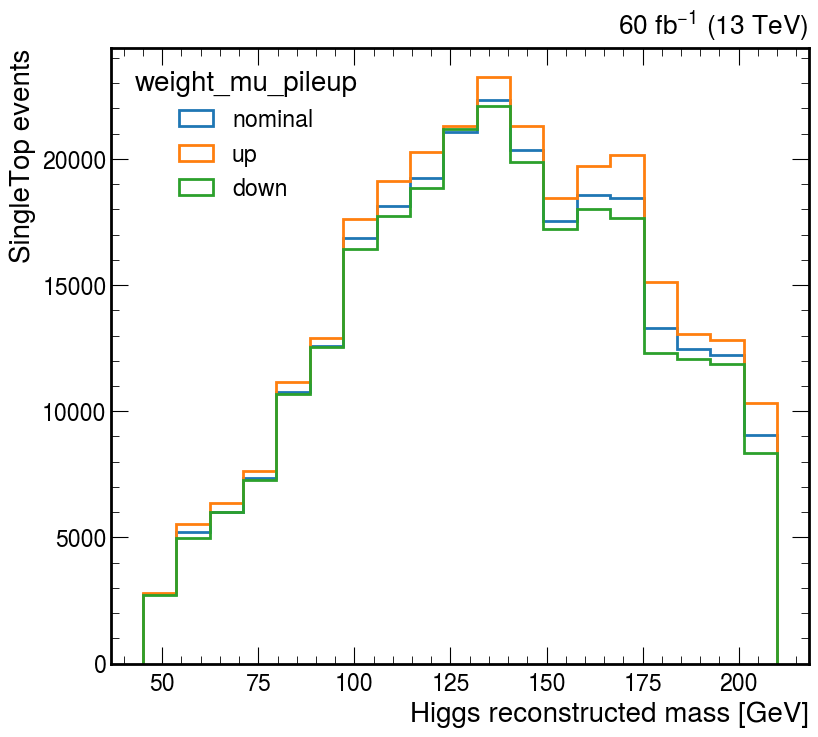

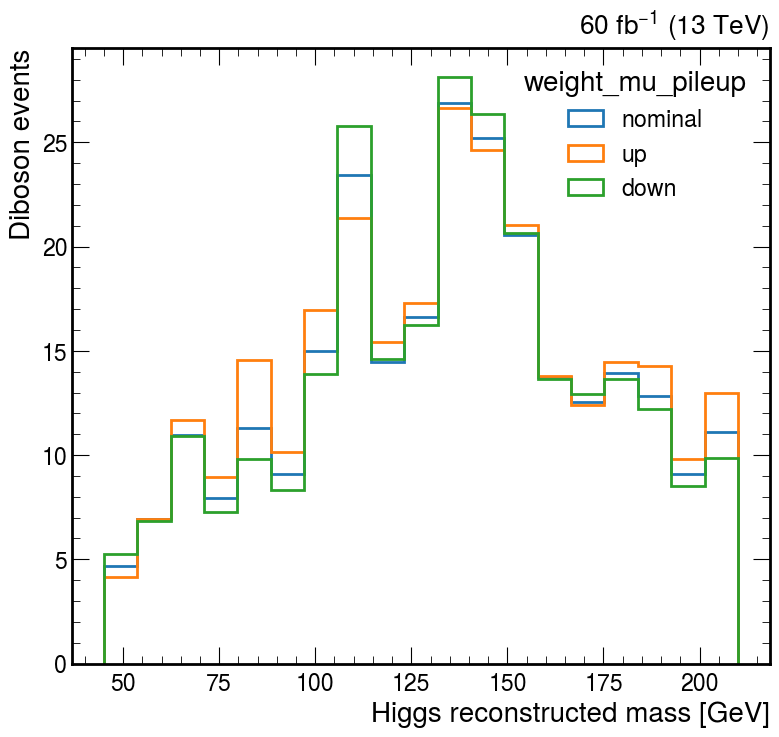

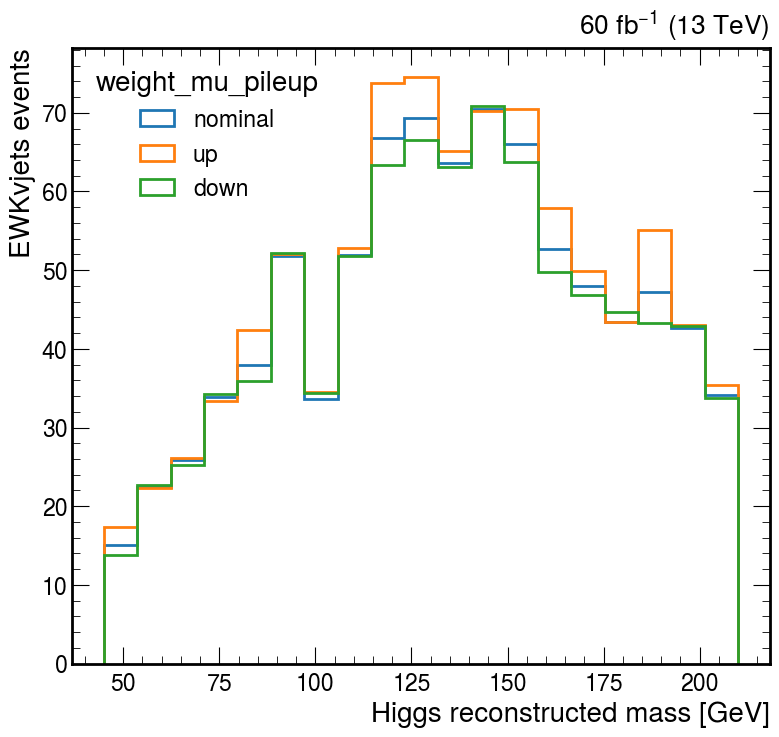

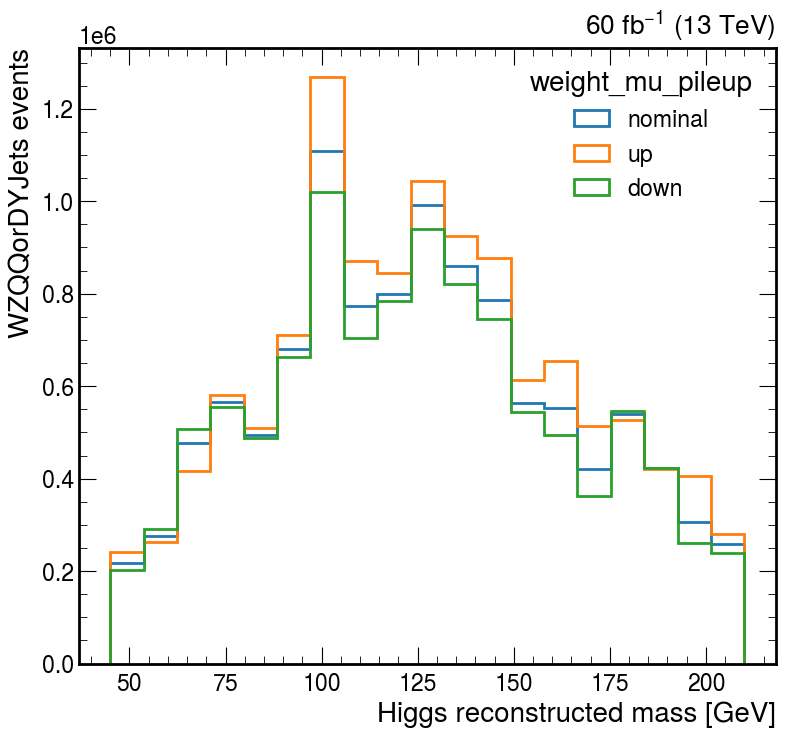

In [36]:
year = "2018"
ch = "mu"
for sample in samples_to_plot:

    df = events_dict["wjetsHT"][year][ch][sample]

    fig, ax = plt.subplots(figsize=(9,8))

    bins = np.linspace(45,210,20)

    syst = f"weight_{ch}_pileup"

    ax.hist(df["rec_higgs_m"], label="nominal", weights=df[f"weight_{ch}"],
            bins=bins, lw=2, histtype="step", 
           )    
    
    ax.hist(df["rec_higgs_m"], label="up", weights=df[f"{syst}Up"],
            bins=bins, lw=2, histtype="step", 
           )

    ax.hist(df[f"rec_higgs_m"], label="down", weights=df[f"{syst}Down"],
            bins=bins, lw=2, histtype="step", 
           )

    ax.legend(title=syst)
    ax.set_xlabel("Higgs reconstructed mass [GeV]")
    ax.set_ylabel(f"{sample} events")
    hep.cms.lumitext("%.0f " % get_lumi([year], [ch]) + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)    
    plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/pileup/{year}_{ch}_{sample}.pdf")
#     break

In [1075]:
((df["lep_isolation"]==0) & (df["lep_pt"]<55)).sum()

283

In [475]:
make_composition_table(events_dict["new_corrections"], presel)

\begin{table}[!ht]
\begin{center}
\caption{Event yield contribution from different processes in the search regions for the full Run2 dataset.}
\begin{tabular}{c|cccc|cccc}
& \multicolumn{4}{c|}{Signal yield} & \multicolumn{4}{c}{Background yield} \\

& ttH & VBF & VH  & ggF & \ttbar & W$+$jets & QCD & Other \\

\hline
\hline
\multirow{2}{*}{Pre-selection} & \multicolumn{4}{c|}{157} & \multicolumn{4}{c}{41393} \\
 & 11\% & 16\% & 18\% & 55\% & 23\% & 58\% & 19\% & 8\% \\

\hline
\hline
\end{tabular}
\label{region}
\end{center}
\end{table}


In [665]:
tagger = "fj_ParT_score"
tagger = "fj_ParT_score_finetuned"

presel = {    
#     "Pre-selection + jetpt>200": f"{tagger}>0.5",    
#     "Pre-selection + jetpt>250": f"{tagger}>0.5 & fj_pt>250",  
#     "Pre-selection + jetpt>300": f"{tagger}>0.5 & fj_pt>300",
        
#     "SR1": f"({tagger}>0.98) & (n_bjets_T==0)",
#     "SR2": f"({tagger}<0.98) & ({tagger}>0.97) & (n_bjets_T==0)",
#     "WJets CR": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0)",
    
#     "WJets CR + jetpt>200": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>200",   
#     "WJets CR + jetpt>250": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>250", 
#     "WJets CR + jetpt>300": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>300", 
      
#     "WJets CR + jetpt>200 + MET>X": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>200", 
#     "WJets CR + jetpt>250 + MET>X": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>250", 
#     "WJets CR + jetpt>300 + MET>X": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>300", 
    
#     "Top CR": f"({tagger}>0.50) & (n_bjets_T>=0)",
}

channels = ["ele", "mu"]
# channels = ["mu"]
years = ["2018", "2017", "2016", "2016APV"]

# fill histograms
var = "met_pt"

# samples = ["ggF", "VBF", "VH", "ttH"]
samples = ["QCD"]
# samples = ["WJetsLNu", "QCD"]
# samples = ["WJetsLNu"]
# samples = ["WJetsLNu", "DYJets"]

# samples = ["TTbar"]
# samples = ["WJetsLNu", "QCD", "TTbar"]


h = hist2.Hist(
#     hist2.axis.StrCategory([], name="corr", growth=True),
    hist2.axis.StrCategory([], name="region", growth=True),    
#     hist2.axis.Variable(list(range(50, 240, 10)), name="var", label=r"Higgs reconstructed mass [GeV]", overflow=True)
#     hist2.axis.Variable(list(range(200, 800, 30)), name="var", label=r"Jet $p_T$ [GeV]", overflow=True)

#     hist2.axis.Variable(list(range(200, 800, 30)), name="var", label=r"Jet $p_T$ [GeV]", overflow=True)
     hist2.axis.Regular(30, 0, 250, name="var", label=r"MET", overflow=True),
)
ev = events_dict["new_corrections200"]

num, den = 0, 0
threshold = 0
for region, sel in presel.items():

    for year in years:
        for ch in channels:   
            for sample in samples:

                df = ev[year][ch][sample]

                df = df.query(sel)    

                if "MET>X" in region:
                    if ch=="ele":
                        df = df[df["met_pt"]>70]
                    else:
                        df = df[df["met_pt"]>50]
                        
#                 if (sample == "QCD") and ("SR" in region):
#                     threshold = 10
#                     den += len(df['event_weight'])
#                     num += sum(df["event_weight"]>threshold)

#                     df = df[df["event_weight"] < threshold]
                    
                h.fill(
                    region=region,
                    var=df[var],
                    weight=df["event_weight"],
                )   


try:
    print(f"Removing {num} out of {den} qcd events by applying qcd event_weight<{threshold} ({(100*num/den):.2f}%)")
except:
    z=1                

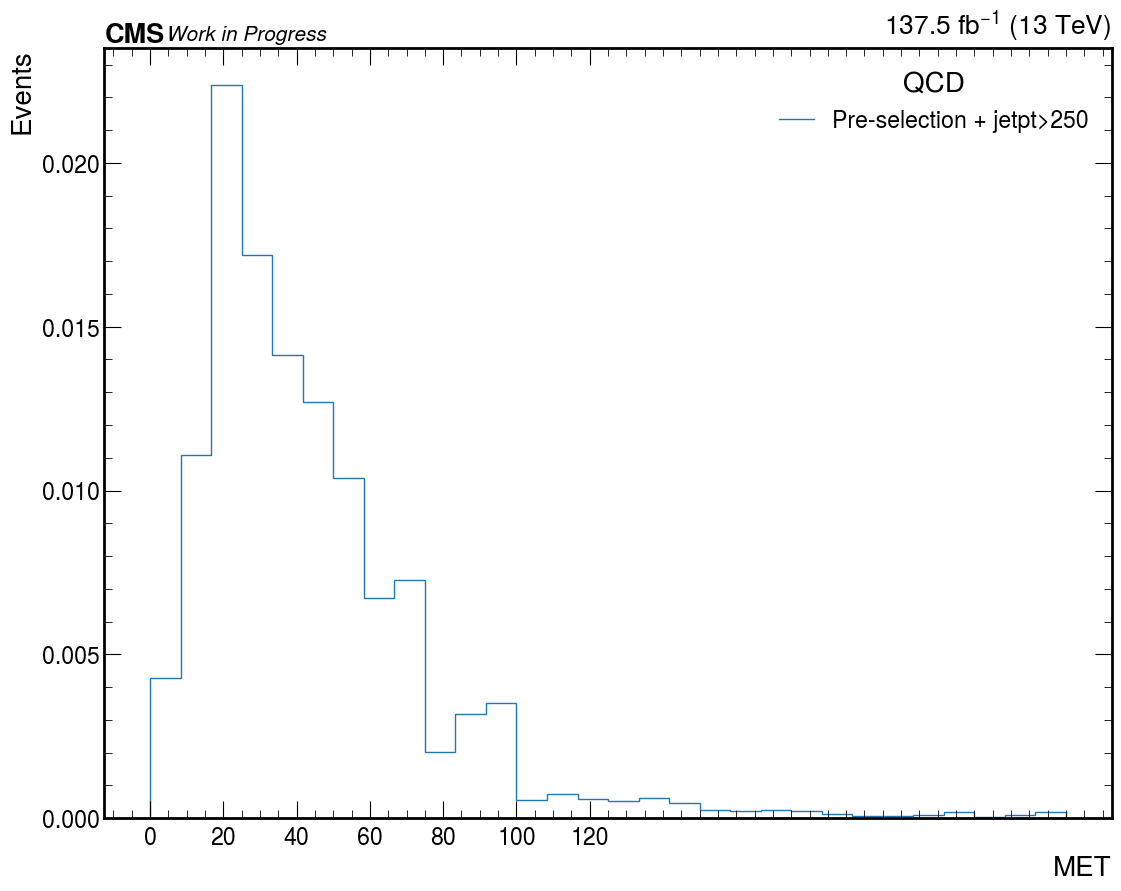

In [541]:
# different regions
fig, ax = plt.subplots(figsize=(13, 10))

for region in presel:
    
    bkg = h[{"region": region}].project("var")    
    
    hep.histplot(
        bkg,
        ax=ax,
        density=True,
        linewidth=1,
        label=region,
        flow="none",
#         color=color_region[region]
    )
    
ax.set_xlabel(bkg.axes.label[0])
ax.legend(title=" + ".join(sample for sample in samples), loc="upper right")
ax.set_ylabel("Events")
# ax.set_ylim(0, 0.015)
# ax.set_yscale("log")

ax.set_xticks([0,20,40,60,80,100,120])

lum_=0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/AN/z.pdf")     

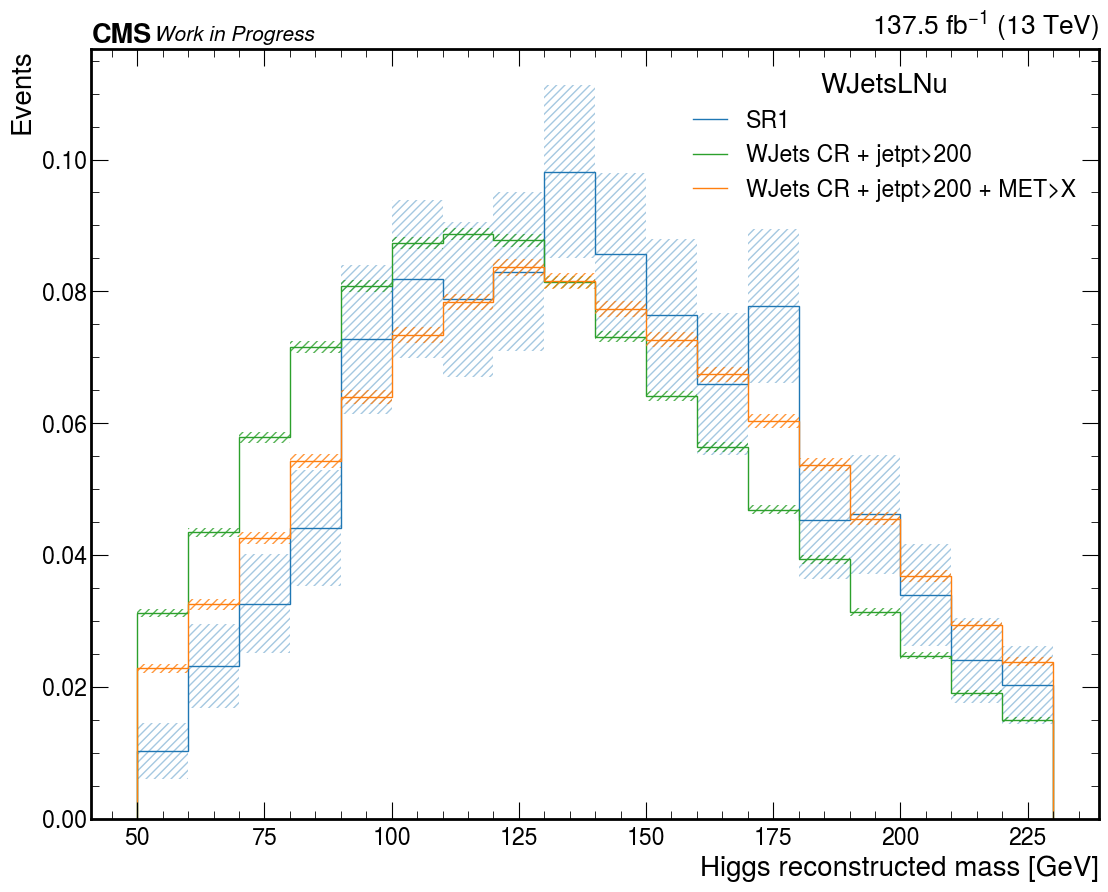

In [243]:
# different regions
fig, ax = plt.subplots(figsize=(13, 10))
color_region = {
    "SR1": "tab:blue",
    "SR2": "tab:orange",
    "WJets CR": "tab:green",
    "Top CR": "tab:green", 
    
    "WJets CR + jetpt>200": "tab:green",
    "WJets CR + jetpt>250": "tab:orange",
    "WJets CR + jetpt>300": "tab:blue",
    
    "WJets CR + jetpt>200 + MET>X": "tab:orange",
    "WJets CR + jetpt>250 + MET>X": "tab:green",
    "WJets CR + jetpt>300 + MET>X": "tab:red",

}

errps = {
    "SR1": {
        "hatch": "////",
        "facecolor": "none",
        "lw": 0,
        "color": color_region["SR1"],
#         "edgecolor": (0, 0, 0, 0.5),
        "linewidth": 0,
        "alpha": 0.4,
    },
    "SR2": {
        "hatch": "////",
        "facecolor": "none",
        "lw": 0,
        "color": color_region["SR2"],
#         "edgecolor": (0, 0, 0, 0.5),
        "linewidth": 0,
        "alpha": 0.4,
    },
    "WJets CR": {
        "hatch": "////",
        "facecolor": "none",
        "lw": 0,
        "color": color_region["WJets CR"],
#         "edgecolor": (0, 0, 0, 0.5),
        "linewidth": 0,
        "alpha": 0.8,
    },   
    "Top CR": {
        "hatch": "////",
        "facecolor": "none",
        "lw": 0,
        "color": color_region["WJets CR"],
#         "edgecolor": (0, 0, 0, 0.5),
        "linewidth": 0,
        "alpha": 0.8,
    },  
    "WJets CR + jetpt>200": {
        "hatch": "////",
        "facecolor": "none",
        "lw": 0,
        "color": color_region["WJets CR + jetpt>200"],
#         "edgecolor": (0, 0, 0, 0.5),
        "linewidth": 0,
        "alpha": 0.8,
    },
    "WJets CR + jetpt>250": {
        "hatch": "////",
        "facecolor": "none",
        "lw": 0,
        "color": color_region["WJets CR + jetpt>250"],
#         "edgecolor": (0, 0, 0, 0.5),
        "linewidth": 0,
        "alpha": 0.8,
    },
    "WJets CR + jetpt>300": {
        "hatch": "////",
        "facecolor": "none",
        "lw": 0,
        "color": color_region["WJets CR + jetpt>300"],
#         "edgecolor": (0, 0, 0, 0.5),
        "linewidth": 0,
        "alpha": 0.8,
    },   
    "WJets CR + jetpt>200 + MET>X": {
        "hatch": "////",
        "facecolor": "none",
        "lw": 0,
        "color": color_region["WJets CR + jetpt>200 + MET>X"],
#         "edgecolor": (0, 0, 0, 0.5),
        "linewidth": 0,
        "alpha": 0.8,
    },       
    
    "WJets CR + jetpt>250 + MET>X": {
        "hatch": "////",
        "facecolor": "none",
        "lw": 0,
        "color": color_region["WJets CR + jetpt>250 + MET>X"],
#         "edgecolor": (0, 0, 0, 0.5),
        "linewidth": 0,
        "alpha": 0.8,
    },       
    
    "WJets CR + jetpt>300 + MET>X": {
        "hatch": "////",
        "facecolor": "none",
        "lw": 0,
        "color": color_region["WJets CR + jetpt>300 + MET>X"],
#         "edgecolor": (0, 0, 0, 0.5),
        "linewidth": 0,
        "alpha": 0.8,
    },       
        
    
}

if False:
    bkg = h[{"region": ["SR1", "SR2"]}].project("var")
    bkg2 = bkg.values()/bkg.values().sum()
    hep.histplot(
    #         bkg,
        bkg2,
        bins=bkg.axes[0].edges,        
        ax=ax,
    #         density=True,
        linewidth=1,
        label="Signal Region (SR1+SR2)",
        flow="none",
    )

    ax.stairs(
        values=(bkg + np.sqrt(bkg))/bkg.values().sum(),
        baseline=(bkg - np.sqrt(bkg))/bkg.values().sum(),
        edges=bkg.axes[0].edges,
        **errps["SR1"],        
        label="Stat. unc.",
    )    
    
for region in presel:
    if "SR2" in region:
        continue

    bkg = h[{"region": region}].project("var")    
    
    bkg2 = bkg.values()/bkg.values().sum()
    hep.histplot(
#         bkg,
        bkg2,
        bins=bkg.axes[0].edges,        
        ax=ax,
#         density=True,
        linewidth=1,
        label=region,
        flow="none",
        color=color_region[region]
    )
    
    ax.stairs(
        values=(bkg + np.sqrt(bkg))/bkg.values().sum(),
        baseline=(bkg - np.sqrt(bkg))/bkg.values().sum(),
        edges=bkg.axes[0].edges,
        **errps[region],        
#         label="Stat. unc.",
    )
    


ax.set_xlabel(bkg.axes.label[0])
ax.legend(title=" + ".join(sample for sample in samples), loc="upper right")
ax.set_ylabel("Events")
# ax.set_ylim(0, 0.015)
# ax.set_yscale("log")

lum_=0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/AN/z.pdf")     

In [550]:
tagger = "fj_ParT_score"
tagger = "fj_ParT_score_finetuned"

presel = {    
    
    
#     "Pre-selection + jetpt>200": f"{tagger}>0.5",    
    "Pre-selection + jetpt>250": f"{tagger}>0.5 & fj_pt>250",  
#     "Pre-selection + jetpt>300": f"{tagger}>0.5 & fj_pt>300",
        
    
#     "SR1": f"({tagger}>0.98) & (n_bjets_T==0)",
#     "SR2": f"({tagger}<0.98) & ({tagger}>0.97) & (n_bjets_T==0)",
#     "WJets CR": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0)",
    
#     "WJets CR + jetpt>200": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>200",   
#     "WJets CR + jetpt>250": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>250", 
#     "WJets CR + jetpt>300": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>300", 
      
#     "WJets CR + jetpt>200 + MET>X": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>200", 
#     "WJets CR + jetpt>250 + MET>X": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>250", 
#     "WJets CR + jetpt>300 + MET>X": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>300", 
    
#     "Top CR": f"({tagger}>0.50) & (n_bjets_T>=0)",      
    

}

channels = ["ele", "mu"]
channels = ["ele"]
years = ["2018", "2017", "2016", "2016APV"]

# fill histograms
var = "met_pt"

# samples = ["ggF", "VBF", "VH", "ttH"]
samples = ["ggF", "QCD"]
# samples = ["WJetsLNu", "DYJets"]

# samples = ["WJetsLNu"]
# samples = ["TTbar"]

h = hist2.Hist(
    hist2.axis.StrCategory([], name="samples", growth=True),        
    hist2.axis.StrCategory([], name="region", growth=True),    
#     hist2.axis.Variable(list(range(50, 240, 10)), name="var", label=r"Higgs reconstructed mass [GeV]", overflow=True)
    hist2.axis.Regular(30, 0, 250, name="var", label=r"MET", overflow=True),
    
)
ev = events_dict["new_corrections"]

num, den = 0, 0
threshold = 0
for region, sel in presel.items():

    for year in years:
        for ch in channels:   
            for sample in samples:

                df = ev[year][ch][sample]

                df = df.query(sel)    

#                 if (sample == "DYJets"):
#                     threshold = 50
#                     den += len(df['event_weight'])
#                     num += sum(df["event_weight"]>threshold)

#                     df = df[df["event_weight"] < threshold]
                    
                h.fill(
                    samples=sample,
                    region=region,
                    var=df[var],
                    weight=df["event_weight"],
                )     
try:
    print(f"Removing {num} out of {den} DYJets events by applying event_weight<{threshold} ({(100*num/den):.2f}%)")
except:
    z=1                             

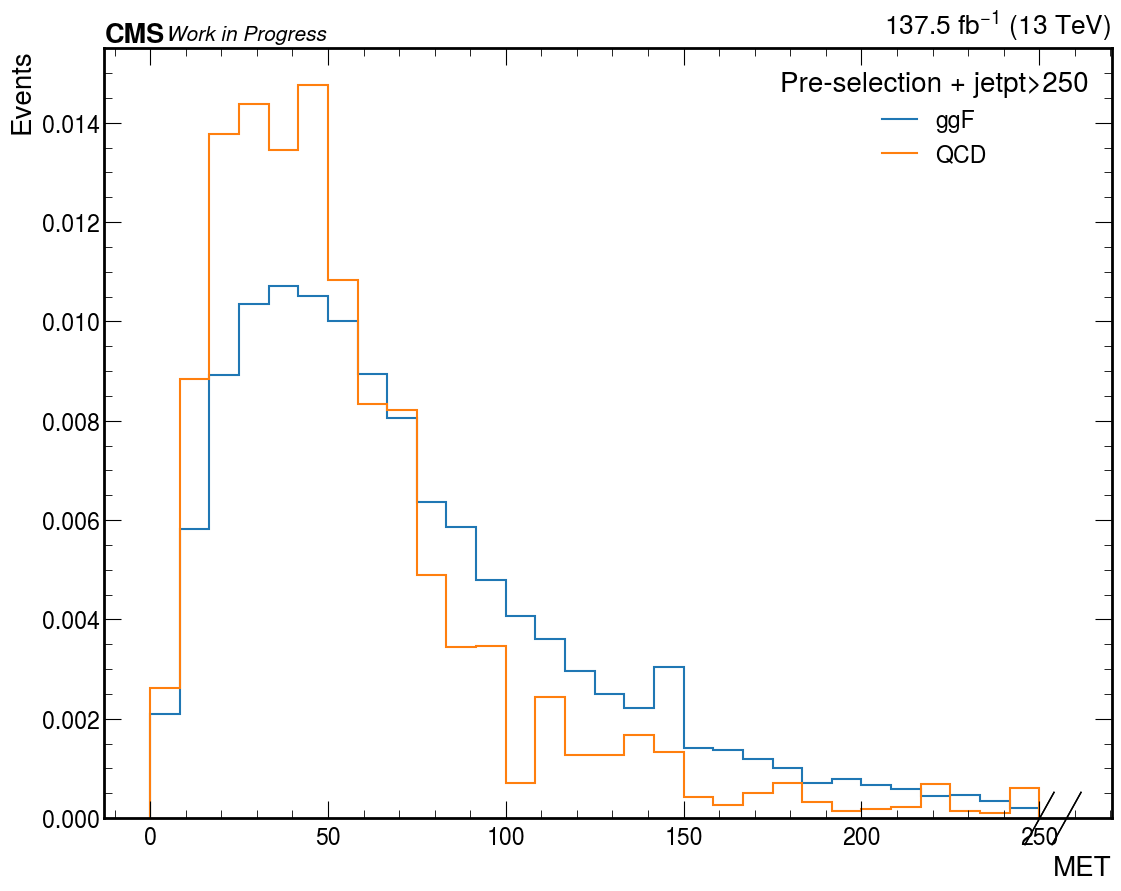

In [553]:
region = "Pre-selection + jetpt>250"
# region = "SR1"

# different regions
fig, ax = plt.subplots(figsize=(13, 10))
for sample in samples:
    hep.histplot(h[{"region": region, "samples": sample}].project("var"),
        label=sample,
        density=True,
#         yerr=True,
    )
ax.legend(title=region, loc="upper right")
ax.set_ylabel("Events")
ax.set_ylim(0)
# ax.set_yscale("log")

lum_=0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/AN/z.pdf")     

In [655]:
tagger = "fj_ParT_score"
tagger = "fj_ParT_score_finetuned"

presel = {    
    
    
    "Pre-selection + jetpt>200": f"{tagger}>0.5",    
    "Pre-selection + jetpt>250": f"{tagger}>0.5 & fj_pt>250",  
    "Pre-selection + jetpt>300": f"{tagger}>0.5 & fj_pt>300",
        
    
#     "SR1": f"({tagger}>0.98) & (n_bjets_T==0)",
#     "SR2": f"({tagger}<0.98) & ({tagger}>0.97) & (n_bjets_T==0)",
#     "WJets CR": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0)",
    
#     "WJets CR + jetpt>200": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>200",   
#     "WJets CR + jetpt>250": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>250", 
#     "WJets CR + jetpt>300": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>300", 
      
#     "WJets CR + jetpt>200 + MET>X": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>200", 
#     "WJets CR + jetpt>250 + MET>X": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>250", 
#     "WJets CR + jetpt>300 + MET>X": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>300", 
    
#     "Top CR": f"({tagger}>0.50) & (n_bjets_T>=0)",      
    

}


years = ["2018", "2017", "2016", "2016APV"]

# fill histograms
var = "met_pt"

samples = ["ggF", "VBF", "VH", "ttH"]
# samples = ["QCD"]
# samples = ["WJetsLNu"]
# samples = ["TTbar"]

h = hist2.Hist(
    hist2.axis.StrCategory([], name="channels", growth=True),        
    hist2.axis.StrCategory([], name="region", growth=True),    
#     hist2.axis.Variable(list(range(50, 240, 10)), name="var", label=r"Higgs reconstructed mass [GeV]", overflow=True)
    hist2.axis.Regular(30, 0, 250, name="var", label=r"MET", overflow=True),
    
)
ev = events_dict["new_corrections200"]
channels = ["ele", "mu"]

num, den = 0, 0
threshold = 0
for region, sel in presel.items():

    for year in years:
        for ch in channels:   
            for sample in samples:

                df = ev[year][ch][sample]

                df = df.query(sel)    

#                 if (sample == "QCD"):
#                     threshold = 200
#                     den += len(df['event_weight'])
#                     num += sum(df["event_weight"]>threshold)

#                     df = df[df["event_weight"] < threshold]
                    
                h.fill(
                    channels=ch,
                    region=region,
                    var=df[var],
                    weight=df["event_weight"],
                )     
try:
    print(f"Removing {num} out of {den} qcd events by applying event_weight<{threshold} ({(100*num/den):.2f}%)")
except:
    z=1                             

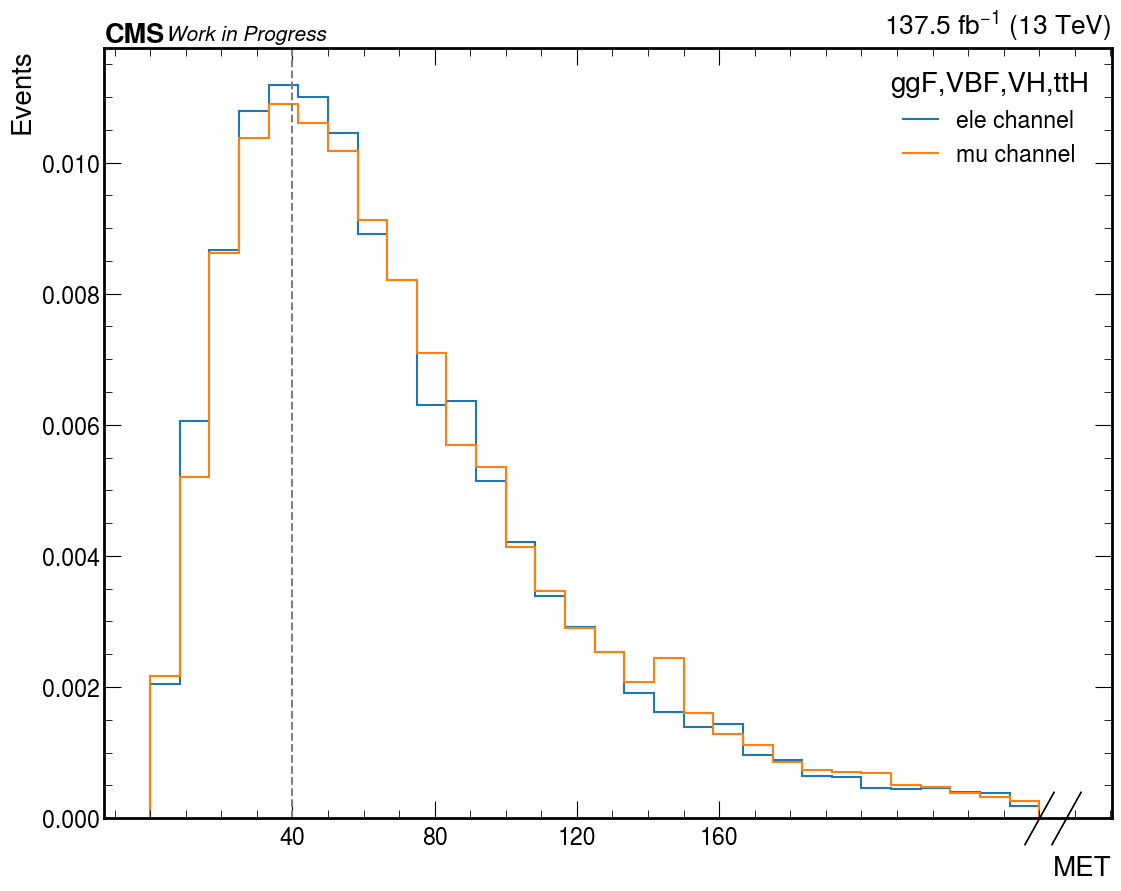

In [656]:
region = "Pre-selection + jetpt>200"
# region = "SR1"

# different regions
fig, ax = plt.subplots(figsize=(13, 10))
for ch in channels:
    hep.histplot(h[{"region": region, "channels": ch}].project("var"),
        label=ch + " channel",
        density=True,
#         yerr=True,
    )
ax.legend(title=",".join(samples), loc="upper right")
ax.set_ylabel("Events")
ax.set_ylim(0)
# ax.set_yscale("log")
ax.axvline(x=40, linestyle="--", color="grey")

ax.set_xticks([40, 80, 120, 160])
lum_=0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/AN/z.pdf")     

# WJetsLNu corrections

In [646]:
tagger = "fj_ParT_score"
tagger = "fj_ParT_score_finetuned"

presel = {    
    
    "Pre-selection": f"{tagger}>0.5",    
    
#     "SR1": f"({tagger}>0.98) & (n_bjets_T==0)",
#     "SR2": f"({tagger}<0.98) & ({tagger}>0.97) & (n_bjets_T==0)",
#     "WJets CR": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0)",
    
#     "WJets CR + jetpt>200": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>200",   
#     "WJets CR + jetpt>250": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>250", 
#     "WJets CR + jetpt>300": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>300", 
      
#     "WJets CR + jetpt>200 + MET>X": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>200", 
#     "WJets CR + jetpt>250 + MET>X": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>250", 
#     "WJets CR + jetpt>300 + MET>X": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>300", 
    
#     "Top CR": f"({tagger}>0.50) & (n_bjets_T>=0)",      
    

}

channels = ["ele", "mu"]
channels = ["ele"]
years = ["2018", "2017", "2016", "2016APV"]

# var = "rec_higgs_m"
var = "fj_pt"
# var = "event_weight"
if var=="rec_higgs_m":
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="corr", growth=True),
        hist2.axis.Variable(list(range(50, 240, 20)), name="var", label=r"Higgs reconstructed mass [GeV]", overflow=True)
    )  
elif var == "fj_pt":
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="corr", growth=True),
        hist2.axis.Variable(list(range(200, 800, 30)), name="var", label=r"Jet $p_T$ [GeV]", overflow=True)
    )  
    
for region, sel in presel.items():

    for year in years:
        for ch in channels:   
            for corr_ in ["old_corrections", "new_corrections"]:

                df = events_dict[corr_][year][ch]["WJetsLNu"]

                df = df.query(sel)    

                h.fill(
                    corr=corr_,
                    var=df[var],
                    weight=df["event_weight"],
                )

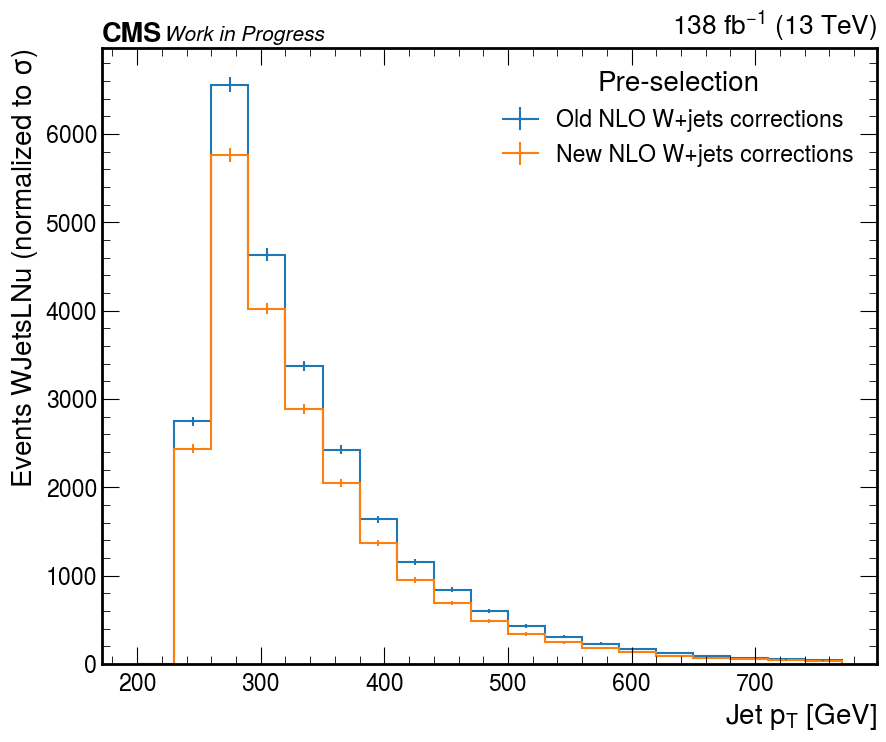

In [661]:
# different corrections

lab_dict = {
    "old_corrections": r"Old NLO W+jets corrections",
    "new_corrections": r"New NLO W+jets corrections",
}

fig, ax = plt.subplots(figsize=(10, 8))
for corr in ["old_corrections", "new_corrections"]:
    hep.histplot(h[{"corr": corr}].project("var"),
        label=lab_dict[corr],
        density=False,
        yerr=True,
        flow=None,
    )
ax.legend(title=region, loc="upper right")
ax.set_ylabel(r"Events WJetsLNu (normalized to $\sigma$)")
# ax.set_ylim(0, 0.013)
# ax.set_yscale("log")

lum_=0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.0f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/AN/wjetscorr.pdf")     

In [161]:
samples_to_plot = [
    'WJetsToLNu_HT-70To100',
    'WJetsToLNu_HT-100To200',
    'WJetsToLNu_HT-200To400',
    'WJetsToLNu_HT-400To600',
    'WJetsToLNu_HT-600To800',
    'WJetsToLNu_HT-800To1200',
    'WJetsToLNu_HT-1200To2500',
    'WJetsToLNu_HT-2500ToInf',    
]

In [181]:
tagger = "fj_ParT_score_finetuned"
presel = {
#     "Pre-selection": f"fj_pt>0",       

    "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20)",
}

channels = ["ele", "mu"]
years = ["2018", "2017", "2016", "2016APV"]

# fill histograms
hists = {}

# var = "rec_higgs_m"
var = "fj_pt"
# var = "event_weight"
if var=="rec_higgs_m":
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        hist2.axis.Variable(list(range(50, 240, 20)), name="var", label=r"Higgs reconstructed mass [GeV]", overflow=True)
    )  
elif var == "fj_pt":
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        hist2.axis.Variable(list(range(200, 800, 30)), name="var", label=r"Jet $p_T$ [GeV]", overflow=True)
    )      

corr = "new_corrections_wjets"
ev = events_dict[corr]

for sample in samples_to_plot:
    for year in years:
        for ch in channels:

            region, sel = list(presel.items())[0]

            try:
                df = ev[year][ch][sample]
                df = df.query(sel)
                if "MET>X" in region:
                    if ch=="ele":
                        df = df[df["met_pt"]>70]
                    else:
                        df = df[df["met_pt"]>50]
                x = df[var]                            
                if len(x)==0:
                    x = 0   
                w = df["event_weight"]
                
            except:
                print(f"{sample} does not exist in {corr}")
                x = 0
                w = 0
                
            h.fill(
                samples=sample, var=x, weight=w,
            )

WJetsToLNu_HT-70To100 does not exist in new_corrections_wjets
WJetsToLNu_HT-70To100 does not exist in new_corrections_wjets
WJetsToLNu_HT-70To100 does not exist in new_corrections_wjets


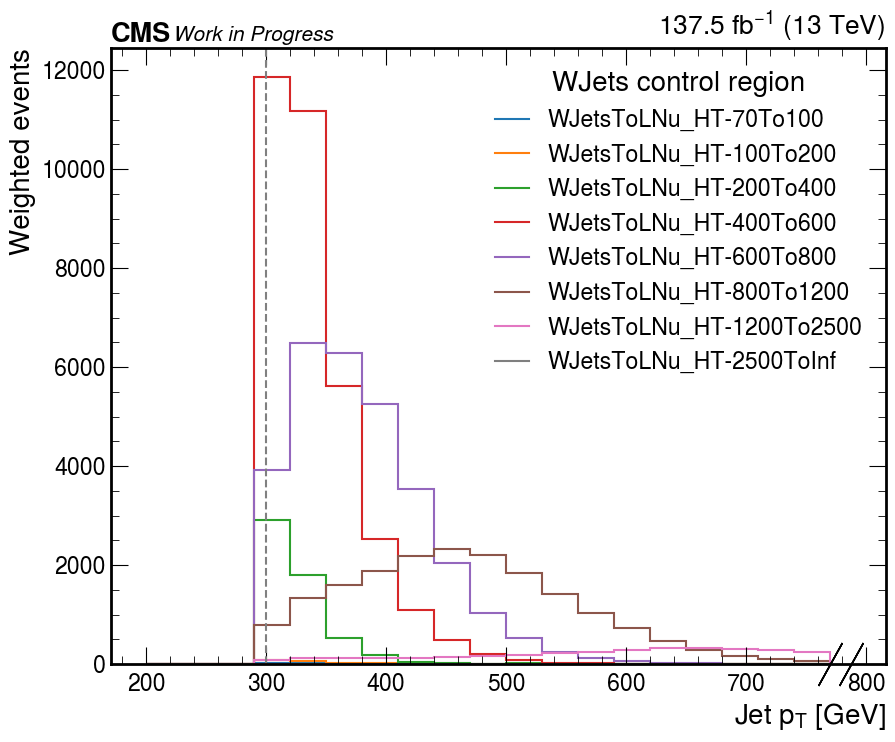

In [182]:
fig, ax = plt.subplots(figsize=(10, 8))
for sample in samples_to_plot:
    hep.histplot(h[{"samples": sample}].project("var"),
        label=sample,
#         density=True,
#         yerr=False,
    )
ax.axvline(300, linestyle="--", color="grey")
ax.legend(title=region, loc="upper right")
ax.set_ylabel("Weighted events")
# ax.set_ylim(0.01, 10e4)
# ax.set_ylim(0, 2500)
# ax.set_yscale("log")

lum_=0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku5/wjetscorr.pdf")     

# High qcd weights

In [1855]:
samples_to_plot = list(events_dictqcd["signal_region"]["2017"]["ele"].keys())
samples_to_plot

['QCD_Pt_3200toInf',
 'QCD_Pt_1800to2400',
 'QCD_Pt_2400to3200',
 'QCD_Pt_1000to1400',
 'QCD_Pt_600to800',
 'QCD_Pt_300to470',
 'QCD_Pt_170to300',
 'QCD_Pt_800to1000',
 'QCD_Pt_470to600',
 'QCD_Pt_1400to1800']

In [1856]:
tagger = "fj_ParT_score_finetuned"
presel = {
    "Pre-selection": f"fj_pt>0",       

#     "High purity signal region": f"({tagger}>0.97)",
#     "High purity signal region + MET>X": f"({tagger}>0.97)",
    
#     "Medium purity signal region": f"({tagger}<0.97) & ({tagger}>0.85)",
#     "Medium purity signal region + MET>X": f"({tagger}<0.97) & ({tagger}>0.85)",
    
#     "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0)",   
#     "WJets control region + MET>X": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0)",   
    
}

channels = ["ele", "mu"]
years = ["2018", "2017", "2016", "2016APV"]

# fill histograms
hists = {}

# var = "rec_higgs_m"
var = "fj_pt"
# var = "event_weight"
if var=="rec_higgs_m":
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        hist2.axis.Variable(list(range(50, 240, 20)), name="var", label=r"Higgs reconstructed mass [GeV]", overflow=True)
    )  
elif var == "fj_pt":
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        hist2.axis.Variable(list(range(200, 800, 30)), name="var", label=r"Jet $p_T$ [GeV]", overflow=True)
    )      
else:
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        hist2.axis.Variable(list(range(0, 500, 20)), name="var", label=r"Event weight", overflow=True)
    )      

for sample in samples_to_plot:
    for year in years:
        for ch in channels:

            region, sel = list(presel.items())[0]

            df = events_dictqcd["signal_region"][year][ch][sample]
            df = df.query(sel)

            if "MET>X" in region:
                if ch=="ele":
                    df = df[df["met_pt"]>70]
                else:
                    df = df[df["met_pt"]>50]

            x = df[var]
            if len(x)==0:
                x = 0   
                
            if var=="event_weight":
                h.fill(
                    samples=sample, var=x,
                )

            else:
                h.fill(
                    samples=sample, var=x, weight=df["event_weight"],
                )

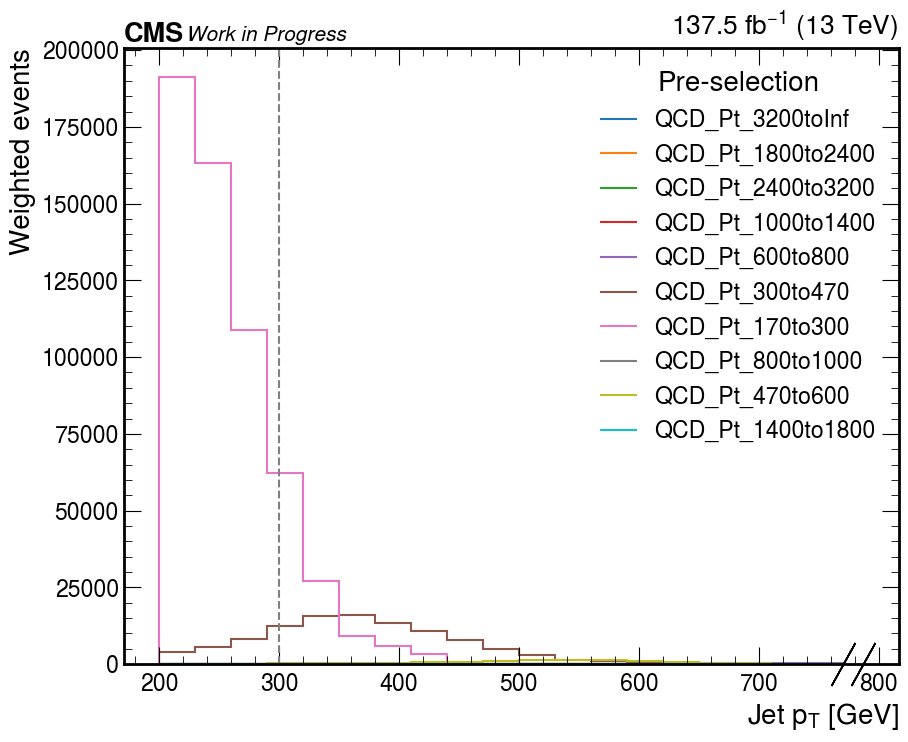

In [1857]:
fig, ax = plt.subplots(figsize=(10, 8))
for sample in samples_to_plot:
    hep.histplot(h[{"samples": sample}].project("var"),
        label=sample,
#         density=True,
#         yerr=False,
    )
ax.axvline(300, linestyle="--", color="grey")
ax.legend(title=region, loc="upper right")
ax.set_ylabel("Weighted events")
# ax.set_ylim(0.01, 10e4)
# ax.set_ylim(0, 2500)
# ax.set_yscale("log")

lum_=0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku5/qcd_high_weights_wjets_jetpt.pdf")     

# soverb

In [149]:
dominant_backgrounds = ["WJetsLNu", "TTbar", "QCD", "DYJets"]

In [150]:
samples

['ggF',
 'VH',
 'VBF',
 'ttH',
 'QCD',
 'DYJets',
 'WJetsLNu',
 'WZQQ',
 'TTbar',
 'SingleTop',
 'Diboson',
 'Data']

In [333]:
# tagger = "ParT_finetuned"
tagger = "fj_ParT_score_finetuned"

presel = {
#     "High purity signal region": f"({tagger}>0.97)",
#     "Medium purity signal region": f"({tagger}<0.97) & ({tagger}>0.85)",
    
#     "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0)", 
    "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20)", 

#     "WJets control region + dR>0.2": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0) & (lep_fj_dr>0.2)",    

#     "Top control region": f"({tagger}<0.2) & (n_bjets_T>0)",  
#     "Top control region + dR>0.1": f"({tagger}<0.20) & (n_bjets_T>0) & (lep_fj_dr>0.1)",      

#     "QCD control region": f"({tagger}<0.20) & (n_bjets_T==0)",  
#     "Lep iso": f"fj_pt>0",
}

categories_sel = {
#     "VBF_pt200toinf": "( (mjj>1000) & (deta>3.5) )",
#     "ggF_pt200to300": "( (mjj<1000) | (deta<3.5) ) & (fj_pt<300)",    
#     "ggF_pt300toinf": "( (mjj<1000) | (deta<3.5) ) & (fj_pt>300)",
    
}

mass_window = [80, 160]

years = ["2018", "2017", "2016APV", "2016"]
channels = ["ele", "mu"]

num_sig = {
    "ggF": 0, 
    "ttH": 0, 
    "VH": 0,
    "VBF": 0,
}
num_bkg = {
    "WJetsLNu": 0, 
    "TTbar": 0, 
    "QCD": 0,
    "DYJets": 0,
    "Others": 0,
}

deno_sig, deno_bkg = 0, 0
s, b = 0, 0

for year in years:
    for ch in channels:
        for sample in samples:
            if sample=="Data":
                continue

            for k, v in presel.items():
                if "QCD" in k:
                    df = events_dict["qcd_region"][year][ch][sample]
                else:
                    df = events_dict["signal_region"][year][ch][sample]

                df = df.query(v)  
                
#                 if "High" in k:
#                     if sample == "QCD":
#                         df = df[df["event_weight"]<140]
#                 if "Medium" in k:
#                     if sample == "QCD":
#                         df = df[df["event_weight"]<200]
            
#             for category, category_sel in categories_sel.items():
#                 df = df.query(category_sel)            
            
#             if sample == "QCD":
#                 df = df[df["event_weight"]<50]
                
#             if ch=="ele":
#                 df = df[df["met_pt"]>70]
#             else:
#                 df = df[df["met_pt"]>50]
                
#             df = df[df["n_bjets_L"]==0]
#             df = df[df["lep_fj_dr"]>0.2]
            df = df[df["lep_met_mt"]>40]
    
#             df = df[(df["fj_pt"]/df["lep_pt"])<3]

#             df = df[np.abs(df["met_fj_dphi"])<2.5]

#             df = df[df["fj_ParT_mass"]<50]

#             df = df[df["fj_pt"]>250]
            ######################## composition start
            if sample in utils.signals:
                
                deno_sig += df["event_weight"].sum()
                num_sig[sample] += df["event_weight"].sum()
            else:
                deno_bkg += df["event_weight"].sum()
                
                if sample in dominant_backgrounds:
                    num_bkg[sample] += df["event_weight"].sum()
                else:
                    num_bkg["Others"] += df["event_weight"].sum()     
            ######################## composition end
            
            ######################## soverb start
            df = df[(df["rec_higgs_m"]>=mass_window[0]) & (df["rec_higgs_m"]<=mass_window[1])]
    
            if sample in utils.signals:                
                s += df["event_weight"].sum()
            else:
                b += df["event_weight"].sum()
            ######################## soverb end

In [334]:
num_sig = dict(sorted(num_sig.items(), key=lambda item: item[1]))
num_bkg = dict(sorted(num_bkg.items(), key=lambda item: item[1]))

if len(years) == 4:
    lab = "Run2"
else:
    lab = "_".join(years)

print("\033[1m" + f"{list(presel.keys())[0]} ({lab}):" + '\033[0m')
# print("Category:", category)

print("------------------------")

if "purity" in list(presel.keys())[0]:
    print("\033[1m" + rf"s/sqrt(b) in [{mass_window[0]},{mass_window[1]}]: {s/math.sqrt(b):.2f}" + '\033[0m')
    print("------------------------")

print(f"Signal: {deno_sig:.2f}")
for sample in num_sig:
    print(f"- {sample}: {100*(num_sig[sample]/deno_sig):.0f}%")
    
print("------------------------")
print(f"Background: {deno_bkg:.2f}")
for sample in num_bkg:
    if sample=="":
        print("\033[1m" + f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.0f}%")
    else:
        print(f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.0f}%") 

WJets control region (Run2):
------------------------
Signal: 475.17
- ttH: 16%
- VH: 17%
- VBF: 20%
- ggF: 47%
------------------------
Background: 497404.16
- Others: 2%
- QCD: 5%
- DYJets: 15%
- TTbar: 18%
- WJetsLNu: 59%


In [587]:
(0.74**2 + 0.81**2 + 0.59**2)**0.5   # VBF / ggF200-300 / ggF300-450 / ggF450-inf

1.2457126474432216

# WJetsLNu region

In [455]:
tagger = "fj_ParT_score_finetuned_v2_nor2"

# mass_window = [50, 200]

years = ["2018", "2017"]
# years = ["2017"]
channels = ["ele", "mu"]

num_sig = {
    "ggF": 0, 
    "ttH": 0, 
    "VH": 0,
    "VBF": 0,
}
num_bkg = {
    "WJetsLNu": 0, 
    "TTbar": 0, 
    "QCD": 0,
    "Others": 0,
}
deno_sig, deno_bkg = 0, 0

# tagger_cuts = [0.01, 0.02, 0.03, 0.04, 0.07, 0.09, 0.1, 0.2, 0.8]
# tagger_cuts = np.linspace(0.01, 0.8, 21)
tagger_cuts = np.linspace(0.01, 0.3, 21)
ttt = []
for tagger_cut in tagger_cuts:
    for year in years:
        for ch in channels:
            for sample in samples:
                if sample=="Data":
                    continue

                df = events_dict[year][ch][sample]

    #             df = df[(df["rec_higgs_m"]>mass_window[0]) & (df["rec_higgs_m"]<mass_window[1])]

                df = df[df["event_weight"]<140]
                df = df[df[tagger]<0.85]
                df = df[df[tagger]>tagger_cut]
                df = df[df["n_bjets_L"]==0]                


                if sample in utils.signals:
                    deno_sig += df["event_weight"].sum()
                    num_sig[sample] += df["event_weight"].sum()
                else:
                    deno_bkg += df["event_weight"].sum()
                    if sample in dominant_backgrounds:
                        num_bkg[sample] += df["event_weight"].sum()
                    else:
                        num_bkg["Others"] += df["event_weight"].sum()
                        
    ttt.append(100*(num_bkg["WJetsLNu"]/deno_bkg))  

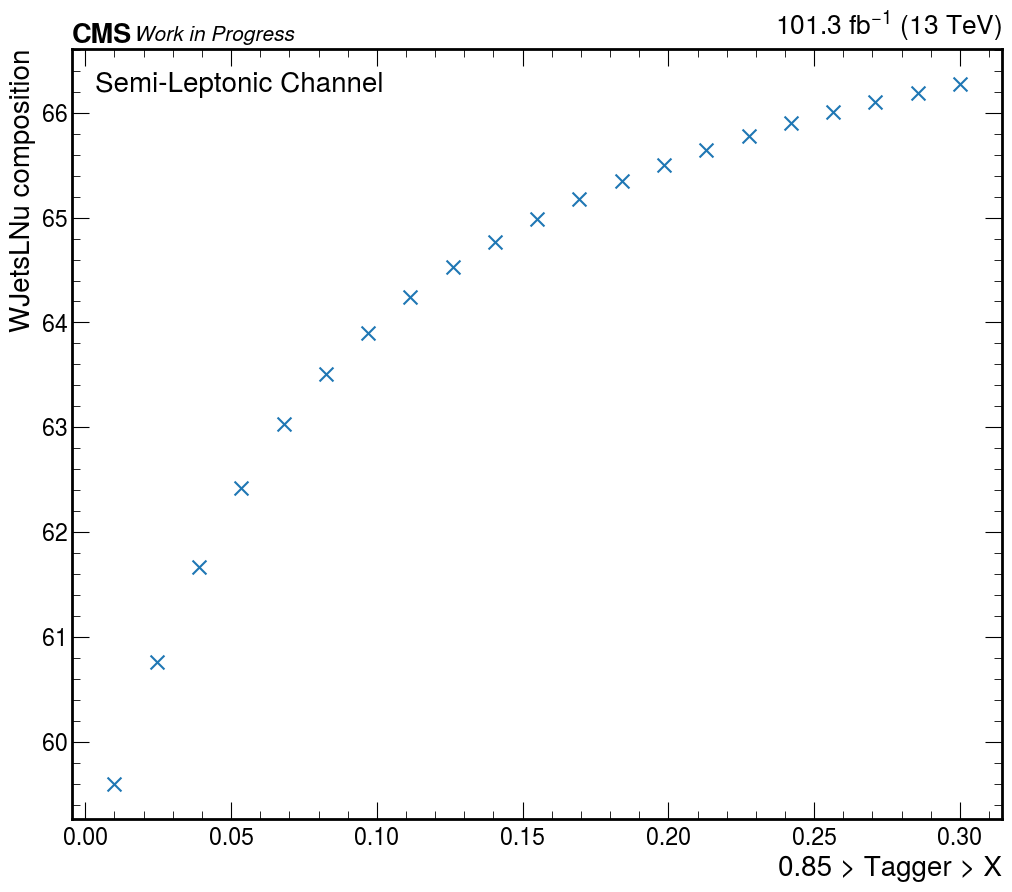

In [456]:
years = ["2018", "2017"]
fig, ax = plt.subplots(figsize=(12, 10))
ax.scatter(tagger_cuts, ttt, marker="x", s=100)

# ax.axvline(0.85, color="grey", linestyle="--")#, label=rf"125 GeV")

# ax.set_ylim(0, 1.4)
ax.legend(title=f"Semi-Leptonic Channel")
ax.set_ylabel(r"WJetsLNu composition");
ax.set_xlabel(r"0.85 > Tagger > X")
# ax.set_xlabel(rf"{wp} > Tagger > X")
# ax.set_xticks(tagger_cuts)
# ax.set_xticks([0.9, 0.92, 0.94, 0.96, 0.97, 0.98])

lum_ = 0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku/soverb_W_region4.pdf")  

# Sculpting

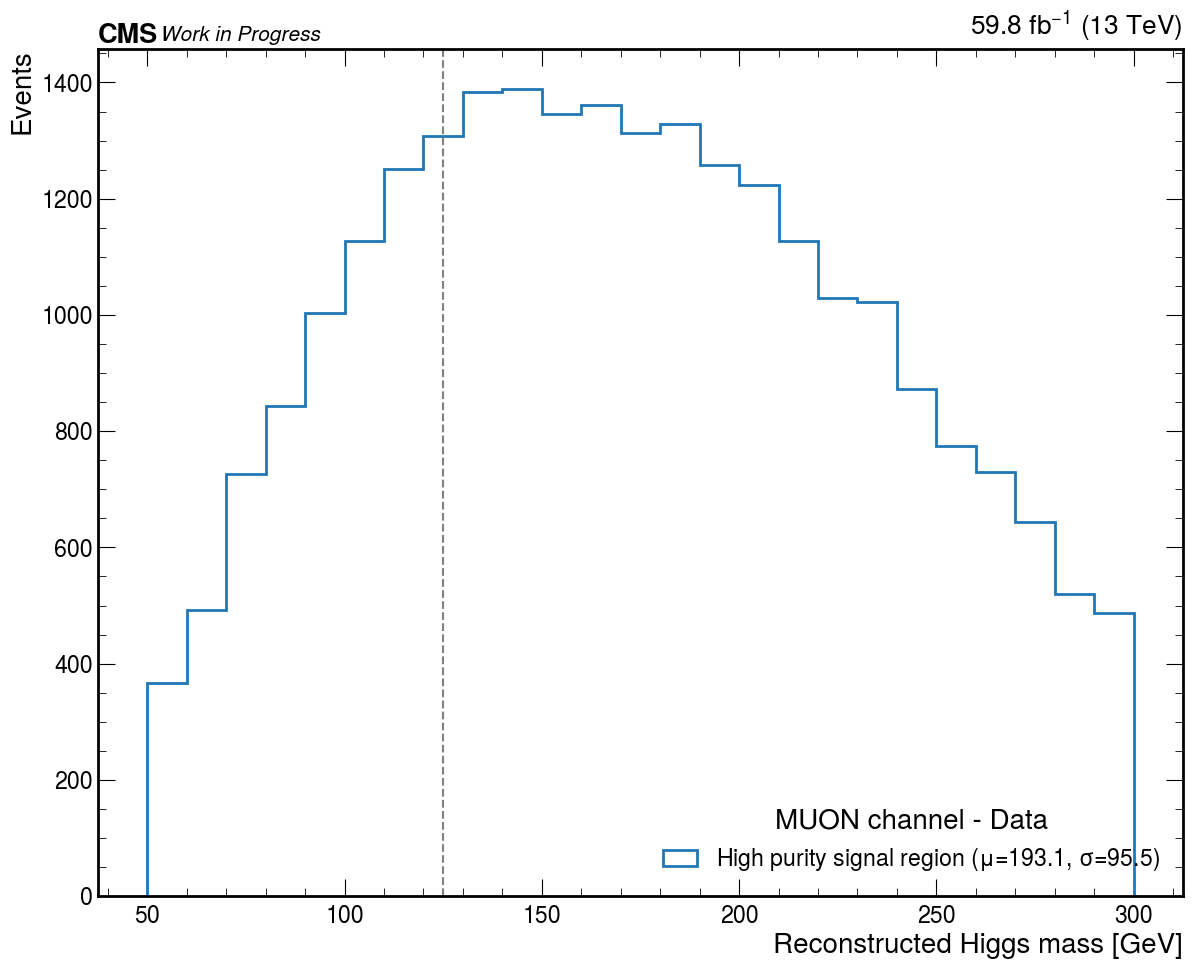

In [531]:
plt.rcParams.update({"font.size": 20})

# tagger = "fj_ParT_score_finetuned_v2_10_12"
tagger = "fj_ParT_score"
# tagger = "fj_ParT_score_finetuned"
presel = {
    "High purity signal region": f"({tagger}>0.97)",
#     "Medium purity signal region": f"({tagger}<0.97) & ({tagger}>0.85)",    
#     "Low purity signal region": f"({tagger}<0.85) & ({tagger}>0.20)",   
    
#     "Top control region": f"({tagger}<0.30) & (n_bjets_T>0)",  

#     "Top control region + dR>0.1": f"({tagger}<0.3) & (n_bjets_T>0) & (lep_fj_dr>0.1)",
#     "Top control region + dR>0.2": f"({tagger}<0.3) & (n_bjets_T>0) & (lep_fj_dr>0.2)",
#     "Top control region + dR>0.3": f"({tagger}<0.3) & (n_bjets_T>0) & (lep_fj_dr>0.3)",
#     "Top control region + dR>0.4": f"({tagger}<0.9) & (n_bjets_T>0) & (lep_fj_dr>0.4)",
    
#     "WJets control region": f"({tagger}<0.80) & ({tagger}>0.20) & (n_bjets_L==0)",

#     "QCD control region": f"({tagger}<0.20) & (n_bjets_T==0)",  
    
#     "ParT-finetuned>0.97": f"(fj_ParT_score_finetuned_v2_nor2>0.97)",
#     "ParT>0.99": f"(fj_ParT_score>0.99)"
    
    
}

nice_ch = {
    "ele": "ELECTRON",
    "mu": "MUON",
}

sample = "Data"
channels = ["mu"]#, "ele"]
years = ["2018"]#, "2017"]

fig, ax = plt.subplots(figsize=(14, 11))
for k, v in presel.items():
    
    for year in years:

        if "QCD" in k:
            region="qcd_region"
        else:
            region="signal_region"

        df1 = events_dict[region][year]["mu"][sample]    
        df2 = events_dict[region][year]["ele"][sample]

        df = pd.concat([df1, df2])

        if len(years) > 1:
            df1 = events_dict[region][years[1]]["mu"][sample]    
            df2 = events_dict[region][years[1]]["ele"][sample]

            df11 = pd.concat([df1, df2])

            df = pd.concat([df, df11])
            break
            
    bins = 26

    df1 = df.copy().query(v)

    x = df1["rec_higgs_m"]
#     w = df1["event_weight"]

    ax.hist(
        x, 
        bins=np.linspace(50,300,bins), 
#         weights=w,
#         density=True, 
        histtype="step", 
        linewidth=2, 
        label=rf"{k} ($\mu$={np.mean(x):.1f}, $\sigma$={np.std(x):.1f})"
    )

ax.axvline(125, color="grey", linestyle="--")#, label=rf"125 GeV")

if len(channels) > 1:
    ax.legend(title=f"{sample}")    
else:
    ax.legend(title=f"{nice_ch[ch]} channel - {sample}")


ax.set_ylabel("Events")
ax.set_xlabel(f"Reconstructed Higgs mass [GeV]")
ax.set_ylim(0)

lum_=0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku/mass_sculpting_{sample}.pdf")        

In [514]:
all_files = glob.glob("ttt/*")
log_files = glob.glob("ttt/log*")

In [505]:
all_files

['ttt/t', 'ttt/log.txt', 'ttt/a.txt']

In [506]:
log_files

['ttt/log.txt']

# Data

In [803]:
# get lumi
with open("../fileset/luminosity.json") as f:
    luminosity = json.load(f)
    
luminosity

{'ele': {'Run2': 137640.0,
  '2016APV': 19492.72,
  '2016': 16809.96,
  '2017': 41476.02,
  '2018': 59816.23},
 'mu': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'lep': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96}}

In [804]:
################### option 2
def blindBins(h, blind_region, blind_samples=[]):
    """
    Blind (i.e. zero) bins in histogram ``h``.
    If ``blind_samples`` specified, only blind those samples, else blinds all.

    CAREFUL: assumes axis=0 is samples, axis=3 is mass_axis

    """

    h = h.copy()

    massbins = h.axes["mass_observable"].edges

    lv = int(np.searchsorted(massbins, blind_region[0], "right"))
    rv = int(np.searchsorted(massbins, blind_region[1], "left") + 1)

    if blind_samples:
        for blind_sample in blind_samples:
            sample_index = np.argmax(np.array(list(h.axes[0])) == blind_sample)
            h.view(flow=True)[sample_index, :, :, lv:rv] = 0

    else:
        h.view(flow=True)[:, :, :, lv:rv] = 0

    return h

plt.rcParams.update({"font.size": 20})

# tagger = "fj_ParT_score"
tagger = "fj_ParT_score_finetuned"

regions_sel = {
#     "Pre-selection": f"{tagger}>0.5",    
    "SR1 (tagger>0.97 + nbjetsT==0)": f"({tagger}>0.97) & (n_bjets_T==0)",
#     "SR2 (0.97>tagger>0.85 + nbjetsT==0)": f"({tagger}<0.97) & ({tagger}>0.85) & (n_bjets_T==0)",
#     "WJets CR (0.85>tagger>0.50 + nbjetsT==0)": f"({tagger}<0.85) & ({tagger}>0.50) & (n_bjets_T==0)",    
#     "Top CR (tagger>0.85 + nbjetsT>0)": f"({tagger}>0.85) & (n_bjets_T>0)", 
    
}

categories_sel = {
    "VBF category": "(mjj>1000) & (deta>3.5)",
#     rf"ggF category ($p_T$ $\in$ [200, 450])": "(mjj<1000) & (deta<3.5) & (fj_pt>200) & (fj_pt<450)",
    rf"ggF category ($p_T$ $\in$ [300, inf])": "(mjj<1000) & (deta<3.5) & (fj_pt>300)",
}

samples = ["Data", "ggF", "VBF"]
channels = ["ele", "mu"]
# channels = ["mu"]
blind = True
blind_region = (90, 160)

years = ["2018", "2017", "2016", "2016APV"]
lum = 0
for year in years:
    lum += luminosity[ch][year] / 1000.0
    

# fill histograms
hists = hist2.Hist(
    hist2.axis.StrCategory([], name="samples", growth=True),            
    hist2.axis.StrCategory([], name="regions", growth=True),
    hist2.axis.StrCategory([], name="categories", growth=True),    
    hist2.axis.Variable(
        list(range(50, 240, 20)), name="mass_observable", label=r"Higgs reconstructed mass [GeV]", overflow=True
    ),
)        

mult = {
    "SR1 (tagger>0.97 + nbjetsT==0)": 10,
#     "SR2 (0.97>tagger>0.85 + nbjetsT==0)": 100,
}

for sample in samples:
    for year in years:
        for ch in channels:
            df = ev[year][ch][sample]
            for region, region_sel in regions_sel.items():
                for category, category_sel in categories_sel.items():
                    df1 = df.copy().query(region_sel)
                    df1 = df1.query(category_sel)

                    if ((sample=="ggF") or (sample=="VBF")):
                        df1["event_weight"]=df1["event_weight"]*mult[region]

                    hists.fill(
                        samples=sample,
                        regions=region,
                        categories=category,
                        mass_observable=df1["rec_higgs_m"],
                        weight=df1["event_weight"],
                    )

INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral


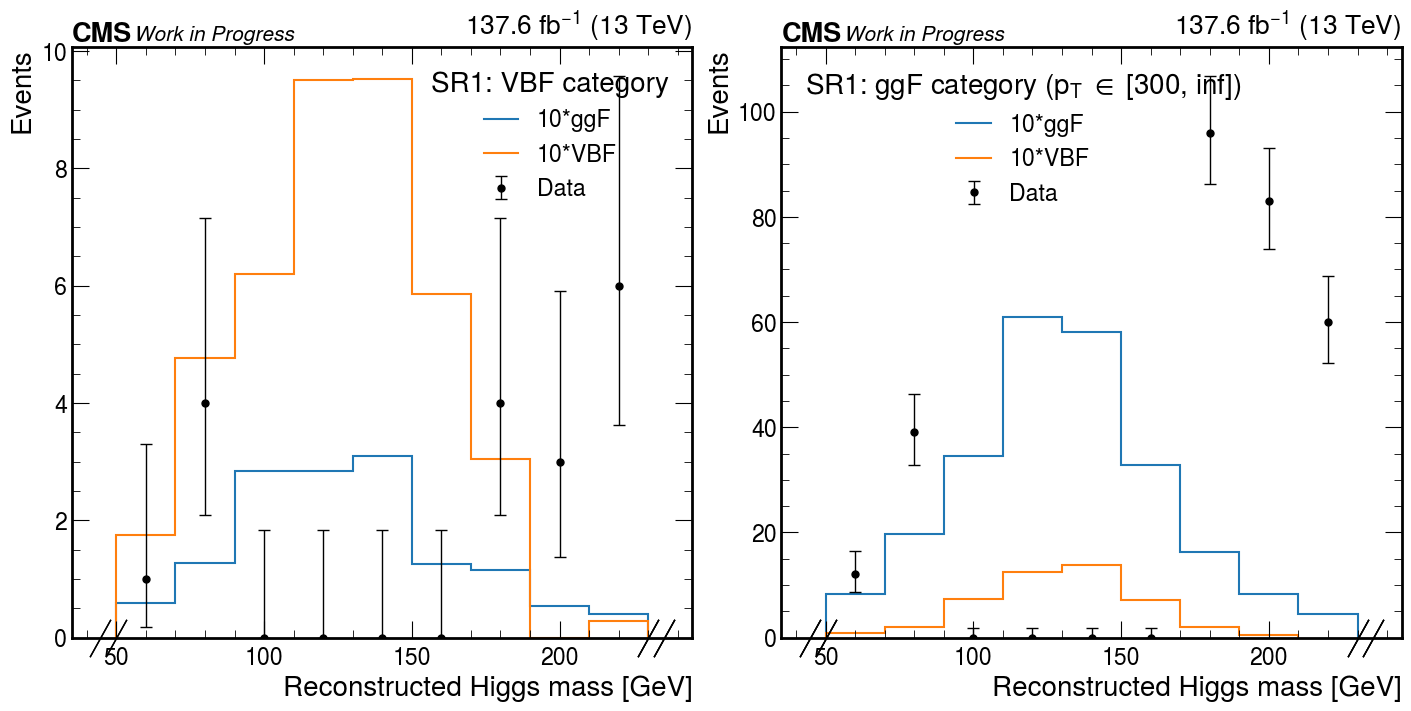

In [805]:
fig, axs = plt.subplots(1, 2, figsize=(14,7), constrained_layout=True)

region = list(regions_sel.items())[0][0]
for i, category in enumerate(categories_sel):
    for sample in samples:
        
        
        if sample == "Data":
            if blind:
                hists = blindBins(hists, (blind_region[0],blind_region[1]), blind_samples=["Data"])
            
            hep.histplot(
                hists[{"samples": sample, "regions": region, "categories": category}],
                ax=axs[i],
                label=sample,
                histtype="errorbar",
                color="k",
                capsize=4,           
            )   
            
        else:
            if mult[region]==1:
                lab = sample            
            else:
                lab = f"{mult[region]}*{sample}"
            
            hep.histplot(
                hists[{"samples": sample, "regions": region, "categories": category}],
                ax=axs[i],
                histtype="step",
                label=lab,
            )    
                

    axs[i].legend(title=f"SR1: {category}")
    axs[i].set_ylabel(f"Events")
    axs[i].set_xlabel(f"Reconstructed Higgs mass [GeV]")
    axs[i].set_ylim(0)    
    hep.cms.lumitext("%.1f " % lum + r"fb$^{-1}$ (13 TeV)", ax=axs[i], fontsize=20)
    hep.cms.text("Work in Progress", ax=axs[i], fontsize=15)
#     if i==2:
#         axs[i].set_yticks([0,4,8,12,16])
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku5/ww3.pdf")

In [1099]:
################### option 2
def blindBins(h, blind_region, blind_samples=[]):
    """
    Blind (i.e. zero) bins in histogram ``h``.
    If ``blind_samples`` specified, only blind those samples, else blinds all.

    CAREFUL: assumes axis=0 is samples, axis=3 is mass_axis

    """

    h = h.copy()

    massbins = h.axes["mass_observable"].edges

    lv = int(np.searchsorted(massbins, blind_region[0], "right"))
    rv = int(np.searchsorted(massbins, blind_region[1], "left") + 1)

    if blind_samples:
        for blind_sample in blind_samples:
            sample_index = np.argmax(np.array(list(h.axes[0])) == blind_sample)
            h.view(flow=True)[sample_index, :, :, lv:rv] = 0

    else:
        h.view(flow=True)[:, :, :, lv:rv] = 0

    return h

plt.rcParams.update({"font.size": 20})

# tagger = "fj_ParT_score"
tagger = "fj_ParT_score_finetuned"

regions_sel = {
#     "Pre-selection": f"{tagger}>0.5",    
    "SR1": f"({tagger}>0.98) & (n_bjets_T==0)",
#     "SR2": f"({tagger}>0.97) & ({tagger}<0.98) & (n_bjets_T==0)",

    
#     "SR1 (tagger>0.97 + nbjetsT==0)": f"({tagger}>0.97) & (n_bjets_T==0)",
#     "SR2 (0.97>tagger>0.85 + nbjetsT==0)": f"({tagger}<0.97) & ({tagger}>0.85) & (n_bjets_T==0)",
#     "WJets CR (0.85>tagger>0.50 + nbjetsT==0)": f"({tagger}<0.85) & ({tagger}>0.50) & (n_bjets_T==0)",    
#     "Top CR (tagger>0.85 + nbjetsT>0)": f"({tagger}>0.85) & (n_bjets_T>0)", 
    
}

categories_sel = {
    "VBF category": "(mjj>1000) & (deta>3.5)",
    rf"ggF category ($p_T$ $\in$ [300, 450])": "(mjj<1000) & (deta<3.5) & (fj_pt>300) & (fj_pt<450)",
    rf"ggF category ($p_T$ $\in$ [450, inf])": "(mjj<1000) & (deta<3.5) & (fj_pt>450)",
    
#     rf"ggF category ($p_T$ $\in$ [300, 450])": "(mjj<1000) & (deta<3.5) & (fj_pt>300) & (fj_pt<450)",
#     rf"ggF category ($p_T$ $\in$ [450, 650])": "(mjj<1000) & (deta<3.5) & (fj_pt>450) & (fj_pt<650)",
#     rf"ggF category ($p_T$ $\in$ [650, inf])": "(mjj<1000) & (deta<3.5) & (fj_pt>650)",        
}

samples = ["Data", "ggF", "VBF"]
channels = ["ele", "mu"]
blind = True
blind_region = (90, 160)

years = ["2018", "2017", "2016", "2016APV"]
lum = 0
for year in years:
    lum += luminosity[ch][year] / 1000.0
    

# fill histograms
hists = hist2.Hist(
    hist2.axis.StrCategory([], name="samples", growth=True),            
    hist2.axis.StrCategory([], name="regions", growth=True),
    hist2.axis.StrCategory([], name="categories", growth=True),    
    hist2.axis.Variable(
        list(range(50, 240, 20)), name="mass_observable", label=r"Higgs reconstructed mass [GeV]", overflow=True
    ),
)        

mult = {
    "SR1": 10,
    "SR2": 100,
}

for sample in samples:
    for year in years:
        for ch in channels:
            df = ev[year][ch][sample]
            for region, region_sel in regions_sel.items():
                for category, category_sel in categories_sel.items():
                    df1 = df.copy().query(region_sel)
                    df1 = df1.query(category_sel)

                    if ((sample=="ggF") or (sample=="VBF")):
                        df1["event_weight"]=df1["event_weight"]*mult[region]

                    hists.fill(
                        samples=sample,
                        regions=region,
                        categories=category,
                        mass_observable=df1["rec_higgs_m"],
                        weight=df1["event_weight"],
                    )

INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral


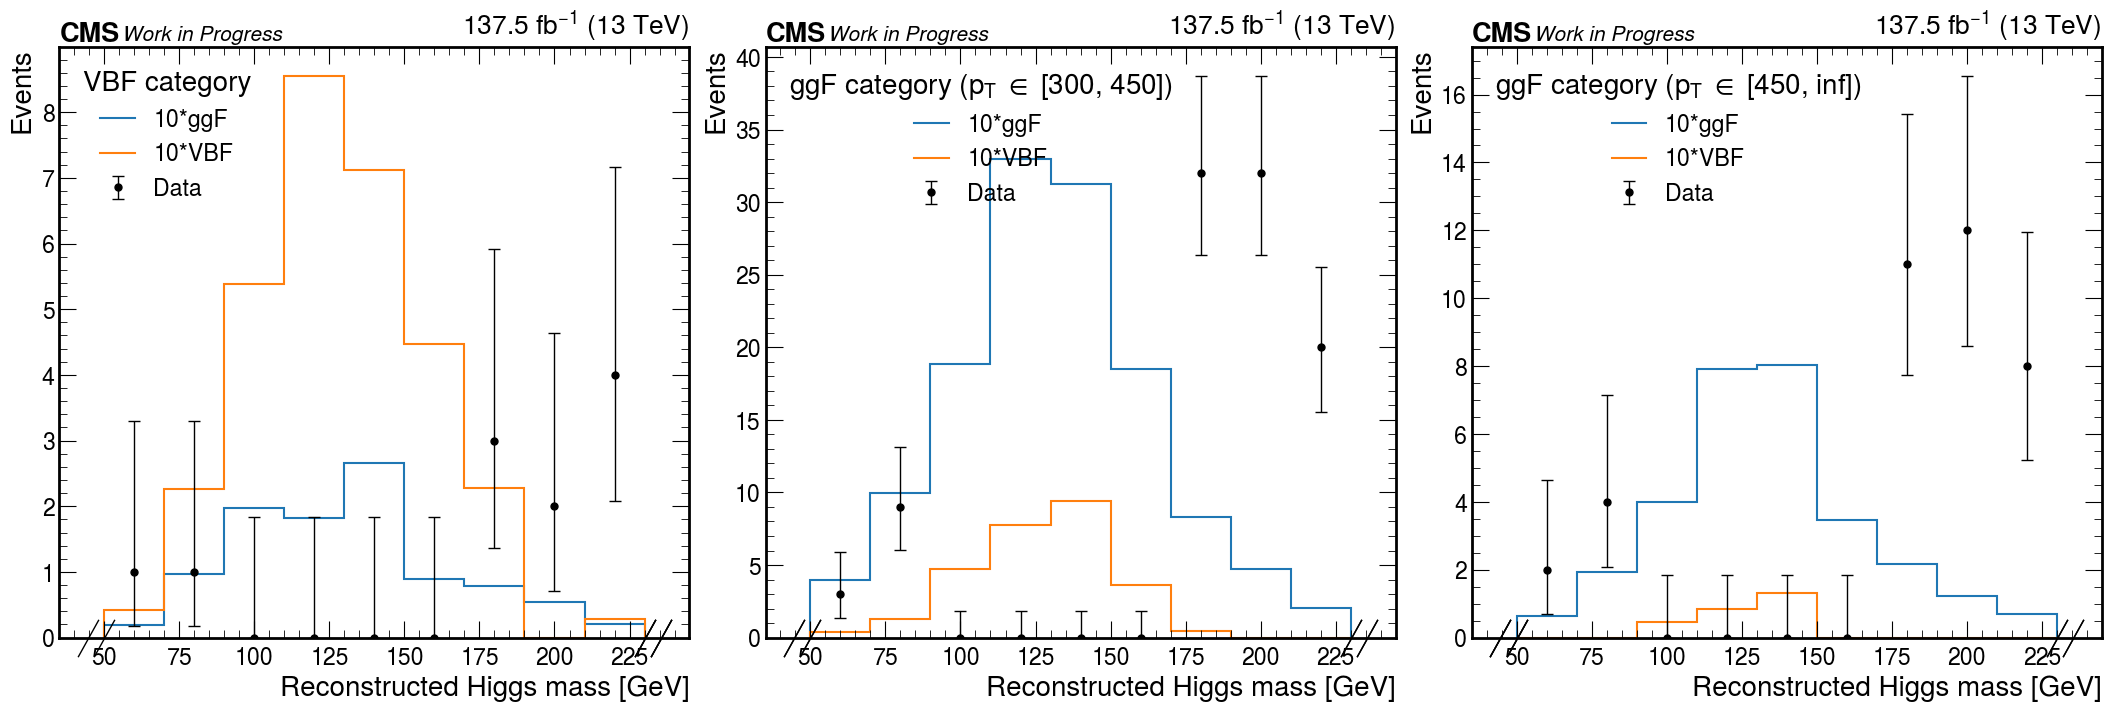

In [1100]:
fig, axs = plt.subplots(1, 3, figsize=(21,7), constrained_layout=True)

region = list(regions_sel.items())[0][0]
for i, category in enumerate(categories_sel):
    for sample in samples:
        
        
        if sample == "Data":
            if blind:
                hists = blindBins(hists, (blind_region[0],blind_region[1]), blind_samples=["Data"])
            
            hep.histplot(
                hists[{"samples": sample, "regions": region, "categories": category}],
                ax=axs[i],
                label=sample,
                histtype="errorbar",
                color="k",
                capsize=4,           
            )   
            
        else:
            if mult[region]==1:
                lab = sample            
            else:
                lab = f"{mult[region]}*{sample}"
            
            hep.histplot(
                hists[{"samples": sample, "regions": region, "categories": category}],
                ax=axs[i],
                histtype="step",
                label=lab,
            )    
            
    axs[i].legend(title=category)
    axs[i].set_ylabel(f"Events")
    axs[i].set_xlabel(f"Reconstructed Higgs mass [GeV]")
    axs[i].set_ylim(0)    
    hep.cms.lumitext("%.1f " % lum + r"fb$^{-1}$ (13 TeV)", ax=axs[i], fontsize=20)
    hep.cms.text("Work in Progress", ax=axs[i], fontsize=15)
#     if i==2:
#         axs[i].set_yticks([0,4,8,12,16])
plt.savefig(f"/Users/fmokhtar/Desktop/AN/ww2.pdf")

In [25]:
################### option 2
def blindBins(h, blind_region, blind_samples=[]):
    """
    Blind (i.e. zero) bins in histogram ``h``.
    If ``blind_samples`` specified, only blind those samples, else blinds all.

    CAREFUL: assumes axis=0 is samples, axis=3 is mass_axis

    """

    h = h.copy()

    massbins = h.axes["mass_observable"].edges

    lv = int(np.searchsorted(massbins, blind_region[0], "right"))
    rv = int(np.searchsorted(massbins, blind_region[1], "left") + 1)

    if blind_samples:
        for blind_sample in blind_samples:
            sample_index = np.argmax(np.array(list(h.axes[0])) == blind_sample)
            h.view(flow=True)[sample_index, :, :, lv:rv] = 0

    else:
        h.view(flow=True)[:, :, :, lv:rv] = 0

    return h

plt.rcParams.update({"font.size": 20})

# tagger = "fj_ParT_score"
tagger = "fj_ParT_score_finetuned"

regions_sel = {
#     "Pre-selection": f"{tagger}>0.5",   
    
    "SR1": f"(n_bjets_T==0)",
    
#     "SR1": f" & (n_bjets_T==0)",
#     "SR2": f"({tagger}>0.97) & ({tagger}<0.98) & (n_bjets_T==0)",

    
#     "SR1 (tagger>0.97 + nbjetsT==0)": f"({tagger}>0.97) & (n_bjets_T==0)",
#     "SR2 (0.97>tagger>0.85 + nbjetsT==0)": f"({tagger}<0.97) & ({tagger}>0.85) & (n_bjets_T==0)",
#     "WJets CR (0.85>tagger>0.50 + nbjetsT==0)": f"({tagger}<0.85) & ({tagger}>0.50) & (n_bjets_T==0)",    
#     "Top CR (tagger>0.85 + nbjetsT>0)": f"({tagger}>0.85) & (n_bjets_T>0)", 
    
}

# categories_sel = {
#     "VBF category": "(mjj>1000) & (deta>3.5)",
#     rf"ggF category ($p_T$ $\in$ [300, 450])": "(mjj<1000) & (deta<3.5) & (fj_pt>300) & (fj_pt<450)",
#     rf"ggF category ($p_T$ $\in$ [450, inf])": "(mjj<1000) & (deta<3.5) & (fj_pt>450)",
    
# #     rf"ggF category ($p_T$ $\in$ [300, 450])": "(mjj<1000) & (deta<3.5) & (fj_pt>300) & (fj_pt<450)",
# #     rf"ggF category ($p_T$ $\in$ [450, 650])": "(mjj<1000) & (deta<3.5) & (fj_pt>450) & (fj_pt<650)",
# #     rf"ggF category ($p_T$ $\in$ [650, inf])": "(mjj<1000) & (deta<3.5) & (fj_pt>650)",        
# }

categories_sel = {
    "SR1": {
        "VBF": f"({tagger}>0.97) & (mjj>1000) & (deta>3.5)",
        rf"ggF $p_T$ $\in$ [250, 300]": f"({tagger}>0.98) & (mjj<1000) & (deta<3.5) & (fj_pt>250) & (fj_pt<300)",        
        rf"ggF $p_T$ $\in$ [300, 450]": f"({tagger}>0.98) & (mjj<1000) & (deta<3.5) & (fj_pt>300) & (fj_pt<450)",
        rf"ggF $p_T$ $\in$ [450, Inf]": f"({tagger}>0.98) & (mjj<1000) & (deta<3.5) & (fj_pt>450)",
    },
    
    "SR2": {
    rf"all inclusive": "(mjj<1000) & (deta<3.5)",
    }
}
#     "VBF category": "(mjj>1000) & (deta>3.5)",
#     rf"ggF category ($p_T$ $\in$ [300, 450])": "(mjj<1000) & (deta<3.5) & (fj_pt>300) & (fj_pt<450)",
#     rf"ggF category ($p_T$ $\in$ [450, inf])": "(mjj<1000) & (deta<3.5) & (fj_pt>450)",
    
#     rf"ggF category ($p_T$ $\in$ [300, 450])": "(mjj<1000) & (deta<3.5) & (fj_pt>300) & (fj_pt<450)",
#     rf"ggF category ($p_T$ $\in$ [450, 650])": "(mjj<1000) & (deta<3.5) & (fj_pt>450) & (fj_pt<650)",
#     rf"ggF category ($p_T$ $\in$ [650, inf])": "(mjj<1000) & (deta<3.5) & (fj_pt>650)",        


samples = ["Data", "ggF", "VBF"]
channels = ["ele", "mu"]
blind = True
blind_region = (90, 160)

years = ["2018", "2017", "2016", "2016APV"]
lum = 0
for year in years:
    lum += luminosity[ch][year] / 1000.0
    

# fill histograms
hists = hist2.Hist(
    hist2.axis.StrCategory([], name="samples", growth=True),            
    hist2.axis.StrCategory([], name="regions", growth=True),
    hist2.axis.StrCategory([], name="categories", growth=True),    
    hist2.axis.Variable(
        list(range(50, 240, 20)), name="mass_observable", label=r"Higgs reconstructed mass [GeV]", overflow=True
    ),
)        

mult = {
    "SR1": 10,
    "SR2": 10,
}

for sample in samples:
    for year in years:
        for ch in channels:
            df = ev[year][ch][sample]
            for region, region_sel in regions_sel.items():

                for category, category_sel in categories_sel[region].items():
                    df1 = df.copy().query(region_sel)
                    df1 = df1.query(category_sel)

                    if ((sample=="ggF") or (sample=="VBF")):
                        df1["event_weight"]=df1["event_weight"]*mult[region]

                    hists.fill(
                        samples=sample,
                        regions=region,
                        categories=category,
                        mass_observable=df1["rec_higgs_m"],
                        weight=df1["event_weight"],
                    )

INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral


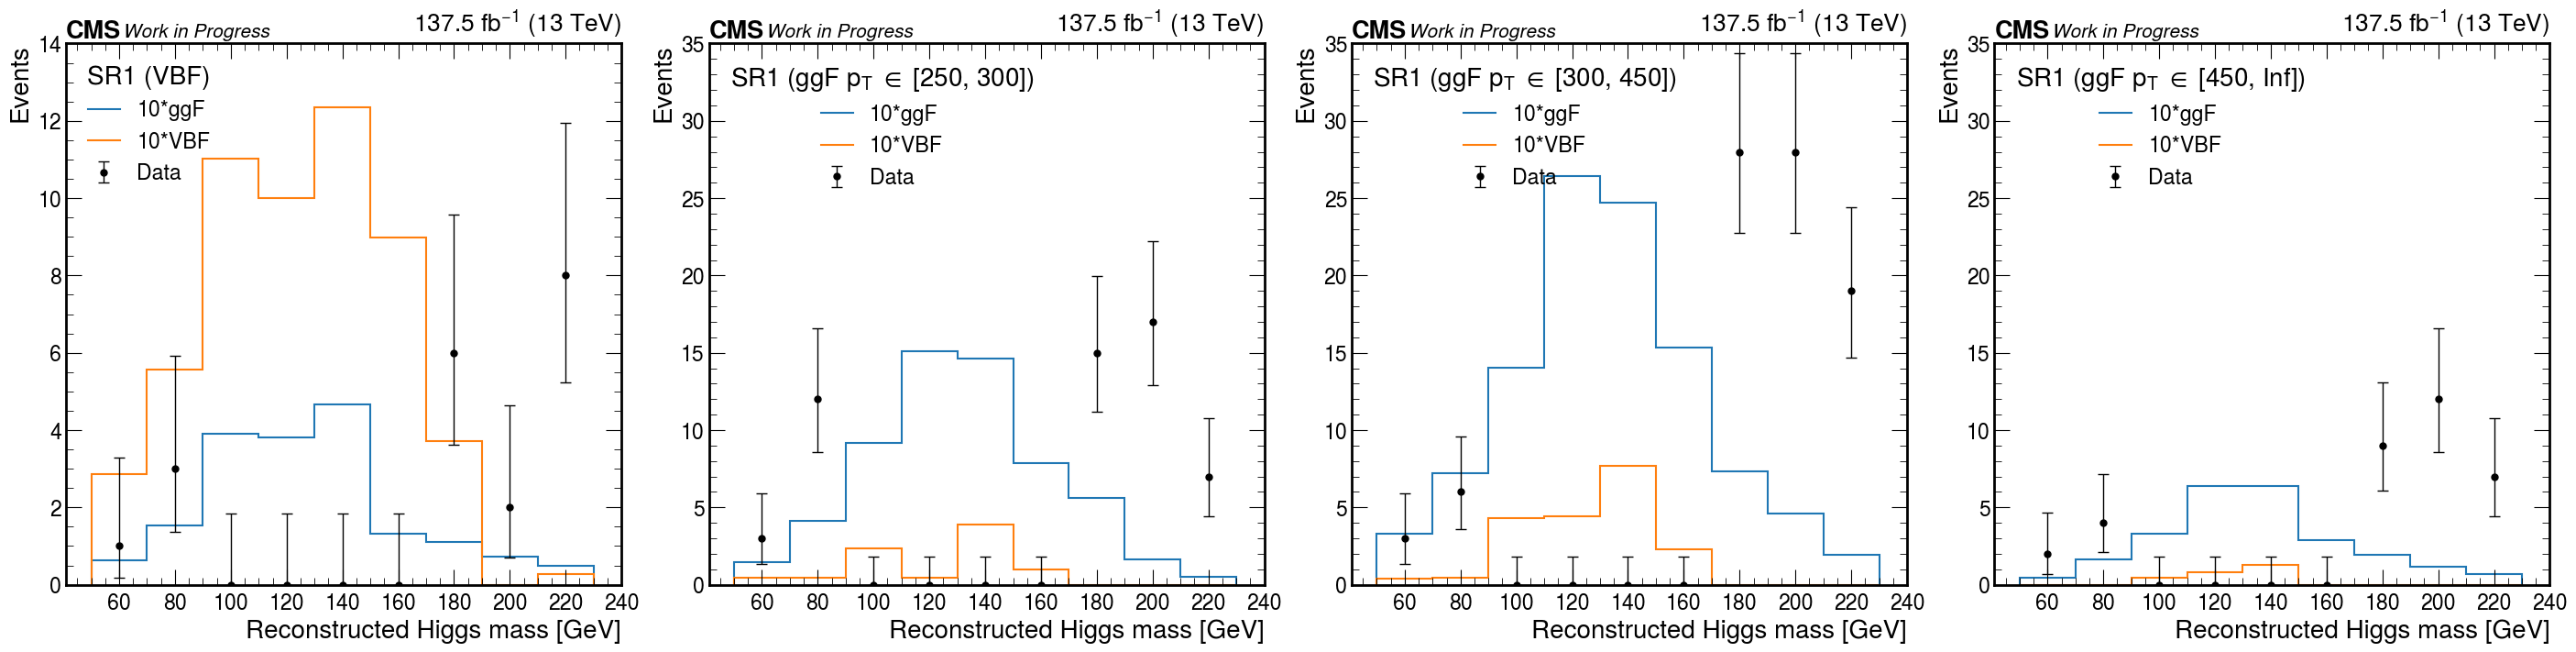

In [31]:
fig, axs = plt.subplots(1, 4, figsize=(28,7), constrained_layout=True)

for region in regions_sel:
    for i, category in enumerate(categories_sel[region]):
        if region=="SR2":
            i=3
        for sample in samples:


            if sample == "Data":
                if blind:
                    hists = blindBins(hists, (blind_region[0],blind_region[1]), blind_samples=["Data"])

                hep.histplot(
                    hists[{"samples": sample, "regions": region, "categories": category}],
                    ax=axs[i],
                    label=sample,
                    histtype="errorbar",
                    color="k",
                    capsize=4,   
                    flow="none"                    
                    
                )   

            else:
                if mult[region]==1:
                    lab = sample            
                else:
                    lab = f"{mult[region]}*{sample}"

                hep.histplot(
                    hists[{"samples": sample, "regions": region, "categories": category}],
                    ax=axs[i],
                    histtype="step",
                    label=lab,
                    flow="none"
                )    
#         if i==3:
#             axs[i].legend(title=f"{region}", loc="upper left")
#         else:
#             axs[i].legend(title=f"{region} ({category})", loc="upper left")

        axs[i].legend(title=f"{region} ({category})", loc="upper left")                

            
        if i==0:
            axs[i].set_ylim(0,14)
        if i==1:
            axs[i].set_ylim(0,35)
        if i==2:
            axs[i].set_ylim(0,35)            
        if i==3:
            axs[i].set_ylim(0,35)
            
            
        axs[i].set_ylabel(f"Events")
        axs[i].set_xlabel(f"Reconstructed Higgs mass [GeV]")
        axs[i].set_ylim(0)    
        hep.cms.lumitext("%.1f " % lum + r"fb$^{-1}$ (13 TeV)", ax=axs[i], fontsize=20)
        hep.cms.text("Work in Progress", ax=axs[i], fontsize=15)
        
        axs[i].set_xticks(np.array(list(range(50, 240, 20))) + 10)
    plt.savefig(f"/Users/fmokhtar/Desktop/AN/ww2.pdf")

# QCD

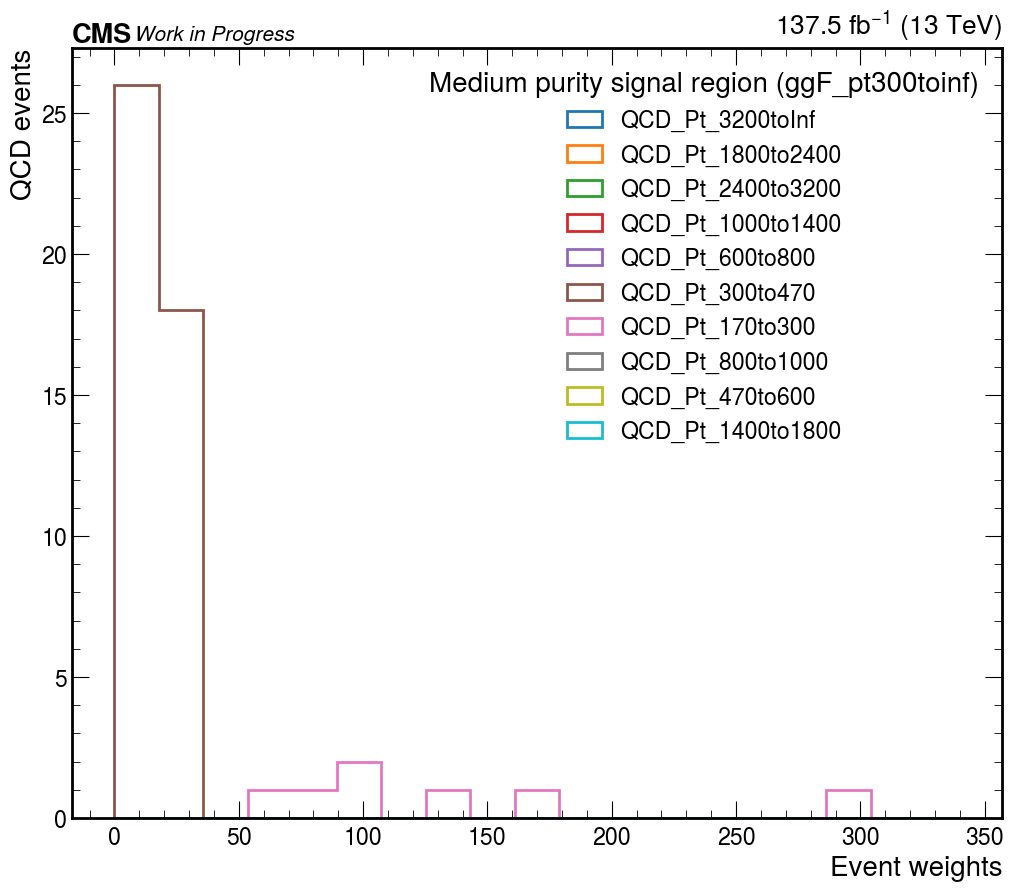

In [573]:
################### option 1
plt.rcParams.update({"font.size": 20})
nice_ch = {
    "ele": "Electron",
    "mu": "Muon",
}

# tagger = "fj_ParT_score"
tagger = "fj_ParT_score_finetuned"

region_sel = {
#     "High purity signal region": f"({tagger}>0.97)",
    "Medium purity signal region": f"({tagger}<0.97) & ({tagger}>0.85)",    
#     "Low purity signal region": f"({tagger}<0.85) & ({tagger}>0.20)",   
    
#     "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0)",
#     "Top control region": f"({tagger}<0.30) & (n_bjets_T>0)",  
#     "QCD control region": f"({tagger}<0.20) & (n_bjets_T==0)",  
}
categories_sel = {
#     "VBF_pt200toinf": "( (mjj>1000) & (deta>3.5) )",
#     "ggF_pt200to300": "( (mjj<1000) & (deta<3.5) & (fj_pt<300) )",
    "ggF_pt300toinf": "( (mjj<1000) & (deta<3.5) & (fj_pt>300) )",
    
}
blind = True
blind_region = (80, 160)
mult = 10

years = ["2018", "2017", "2016APV", "2016"]
sample="QCD"

fig, ax = plt.subplots(figsize=(12,10))    

ws = {}

for sample in events_dict2["signal_region"]["2017"][ch]:
    ws[sample] = []
    for year in years:
        for ch in ["ele", "mu"]:
            try:
                df = events_dict2["signal_region"][year][ch][sample]
            except:
                continue

            for region, sel in region_sel.items():
                df = df.query(sel)

            for category, category_sel in categories_sel.items():
                df = df.query(category_sel)

            w = df[f"event_weight"]
            ws[sample] += w.tolist() 
    
    ws[sample] = np.array(ws[sample])
    ws[sample] = ws[sample][ws[sample]>10]

    bins = 20
    ax.hist(
        ws[sample],
        bins=np.linspace(0,340,bins), 
        histtype="step", 
        linewidth=2, 
        label=sample
    )
#     break

lum = 0
for year in years:
    lum += luminosity[ch][year] / 1000.0

ax.legend(title=f"{region} ({category})", loc="upper right")

ax.set_ylabel(f"QCD events")
ax.set_xlabel(f"Event weights")  
ax.set_ylim(0)

hep.cms.lumitext("%.1f " % lum + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku2/WWW_QCD_weights_medium_{category}.pdf")        

In [740]:
def plot_ratio(h, years, region1 = "Medium_signal_region", region2 = "QCD_region", sample="QCD", category="VBF", tag=""):
    
    fig, (ax, rax) = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=(10, 10),
        gridspec_kw={"height_ratios": (4, 2), "hspace": 0.07},
        sharex=True,
    )

    hep.histplot(
        h[{"region": region1, "categories": category}],
        ax=ax,
#         histtype="step",
        histtype="errorbar",        
        label=region1,
        density=True
    )
    hep.histplot(
        h[{"region": region2, "categories": category}],
        ax=ax,
        histtype="step",
        label=region2,
        density=True    
    )

    from hist.intervals import ratio_uncertainty

    data_val = h[{"region": region1, "categories": category}].values()
    tot_val = h[{"region": region2, "categories": category}].values()
    yerr = ratio_uncertainty(data_val, tot_val, "poisson")
    

    data_val /= data_val.sum()
    tot_val /= tot_val.sum()


    hep.histplot(
        data_val / tot_val,
        h[{"region": region1, "categories": category}].axes.edges[0],
        yerr=yerr,
        ax=rax,
        histtype="step",
        color="k",
#         capsize=4,
    )
    ax.set_xlabel("")
    rax.set_xlabel(f"{h.axes[-1].label}")  # assumes the variable to be plotted is at the last axis

    rax.set_ylabel("Ratio", fontsize=20, loc="center")

    
#     rax.set_ylim(0, 0.004)
#     rax.set_yticks([0, 0.4, 1, 1.4])
    
    rax.axhline(1, ls="--", color="k")    
#     rax.set_ylim(0, 2.5)
#     rax.set_yticks([0, 0.4, 1, 1.4])

    ax.legend(title=category)
    
    lum_ = 0
    for year in years:
        lum = 0
        for ch in ["ele", "mu"]:
            with open("../fileset/luminosity.json") as f:
                lum += json.load(f)[ch][year] / 1000.0

        lum_ += lum / len(channels)

    hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)

    hep.cms.text("Work in Progress", ax=ax, fontsize=15)
    
    
    ax.set_ylabel(f"Normalized {sample} events")
    
    if tag:
        plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku3/ratio_{sample}_{tag}.pdf")        
    else:
        plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku3/ratio_{sample}.pdf")   

In [741]:
tagger = "fj_ParT_score_finetuned"
presel = {
    "High purity signal region": f"({tagger}>0.97)",
    "Medium purity signal region": f"({tagger}<0.97) & ({tagger}>0.85)",
    "Low purity signal region": f"({tagger}<0.85) & ({tagger}>0.20)",
    "0.85>Tagger>0.20": f"({tagger}<0.85) & ({tagger}>0.20)",

#     "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0)",   
    
#     "Top control region": f"({tagger}<0.20) & (n_bjets_T>0)",  
    "QCD control region": f"({tagger}<0.20) & (n_bjets_T==0)",  

}

categories_sel = {
    "VBF_pt200toinf": "( (mjj>1000) & (deta>3.5) )",
    "ggF_pt200to300": "( (mjj<1000) & (deta<3.5) & (fj_pt<300) )",
    "ggF_pt300toinf": "( (mjj<1000) & (deta<3.5) & (fj_pt>300) )",
    
}
            
channels = ["ele", "mu"]
years = ["2018", "2017", "2016", "2016APV"]

sample = "QCD"

# fill histograms
hists = {}
for var in vars_to_plot:
            
    if var == "rec_higgs_m":
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="region", growth=True),
            hist2.axis.StrCategory([], name="categories", growth=True),            
            hist2.axis.Variable(
                list(range(50, 240, 20)), name="mass_observable", label=r"Higgs reconstructed mass [GeV]", overflow=True
            )
        )
    else:
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="region", growth=True),
            utils.axis_dict[var],
        )
        
    for year in years:
        for ch in channels:
                
            for region, region_sel in presel.items():
                for category, category_sel in categories_sel.items():
                
                    if "QCD control region" in region:
                        df = events_dict["qcd_region"][year][ch][sample]
                    else:
                        df = events_dict["signal_region"][year][ch][sample]

                    if "High" in region:
                        if sample == "QCD":
                            df = df[df["event_weight"]<140]
                    elif "Medium" in region:
                        if sample == "QCD":
                            df = df[df["event_weight"]<200]

                    df = df.query(region_sel)
                    df = df.query(category_sel)

                    hists[var].fill(
                        region=region,
                        categories=category,
                        mass_observable=df[var],
                        weight=df["event_weight"],
                    )     

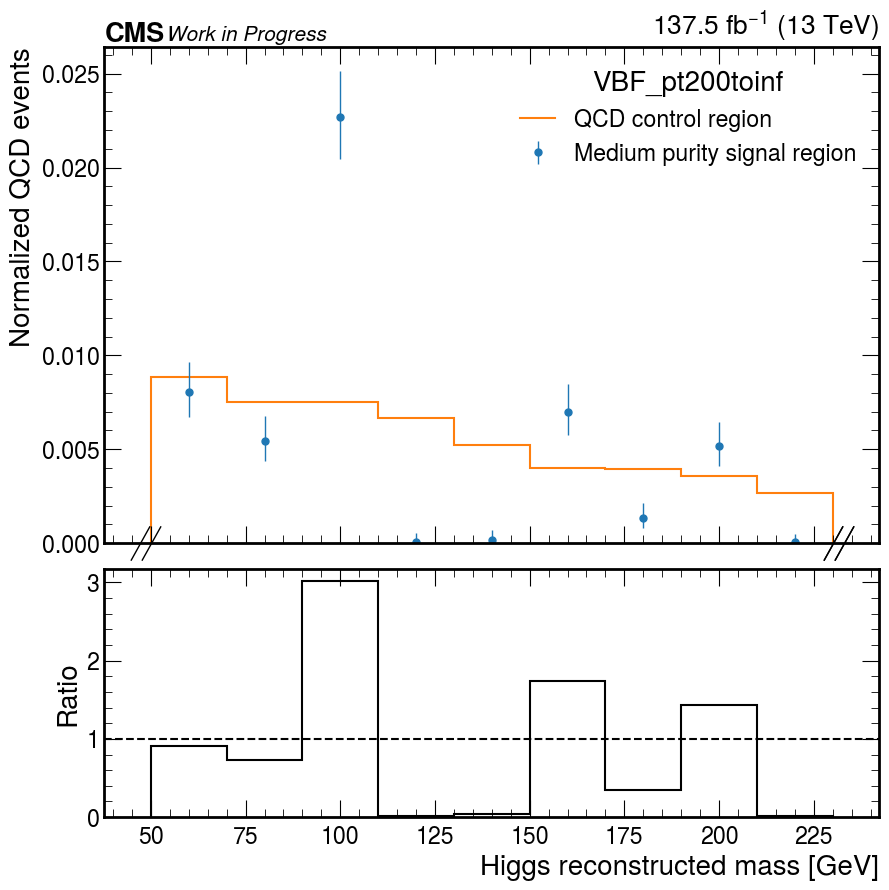

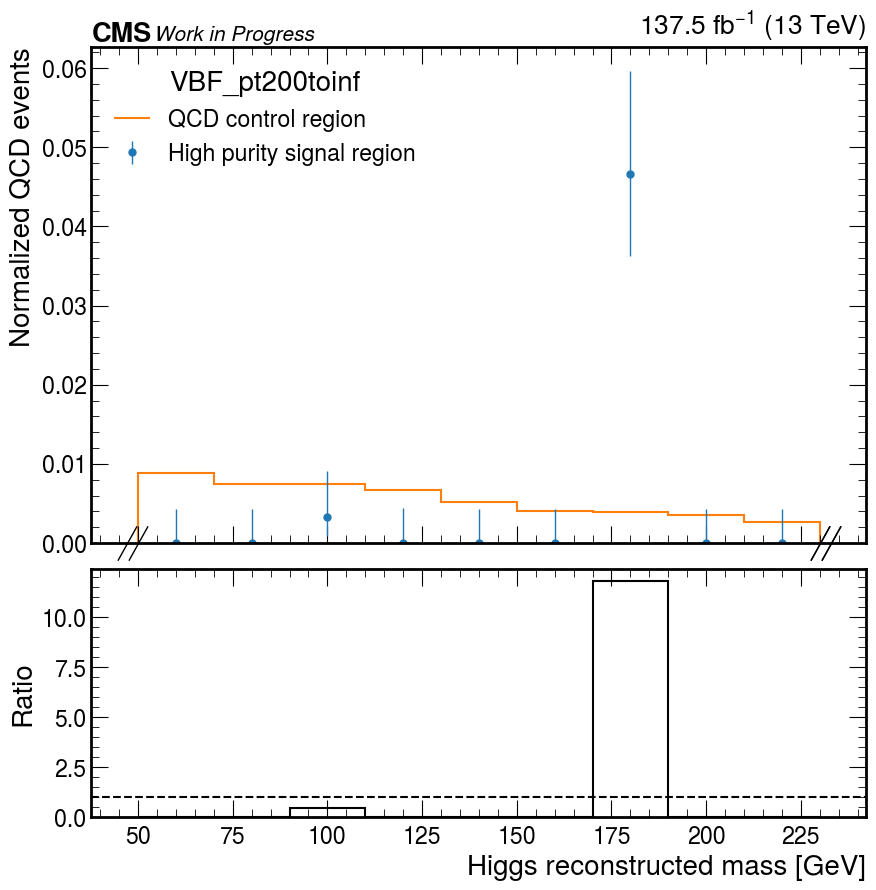

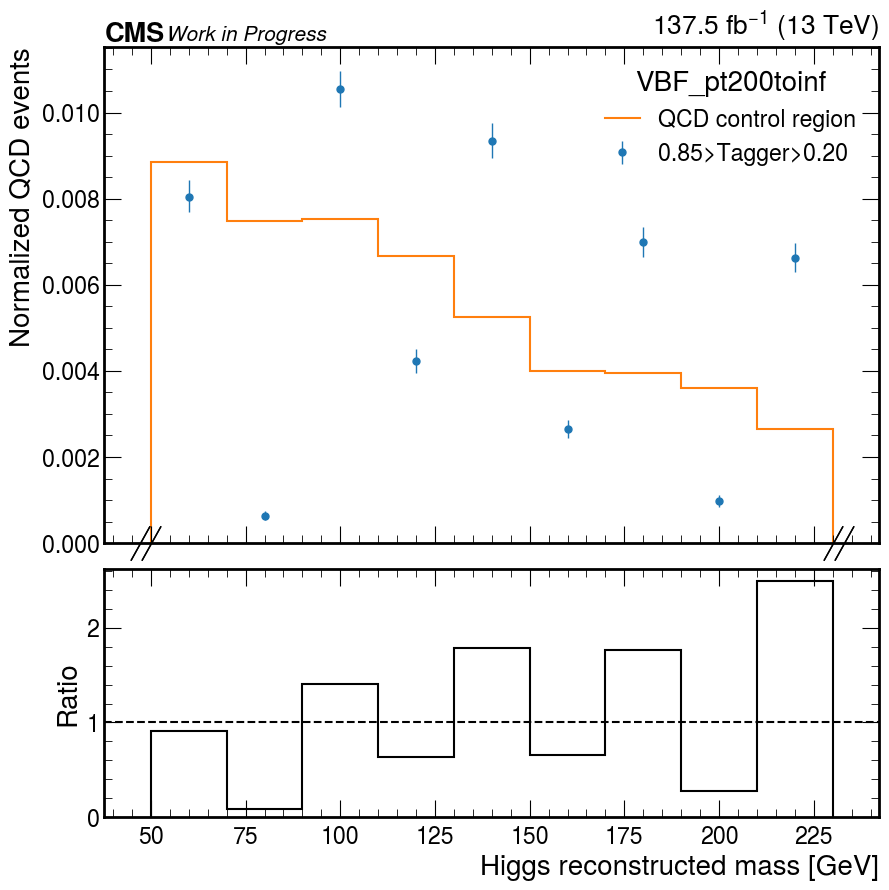

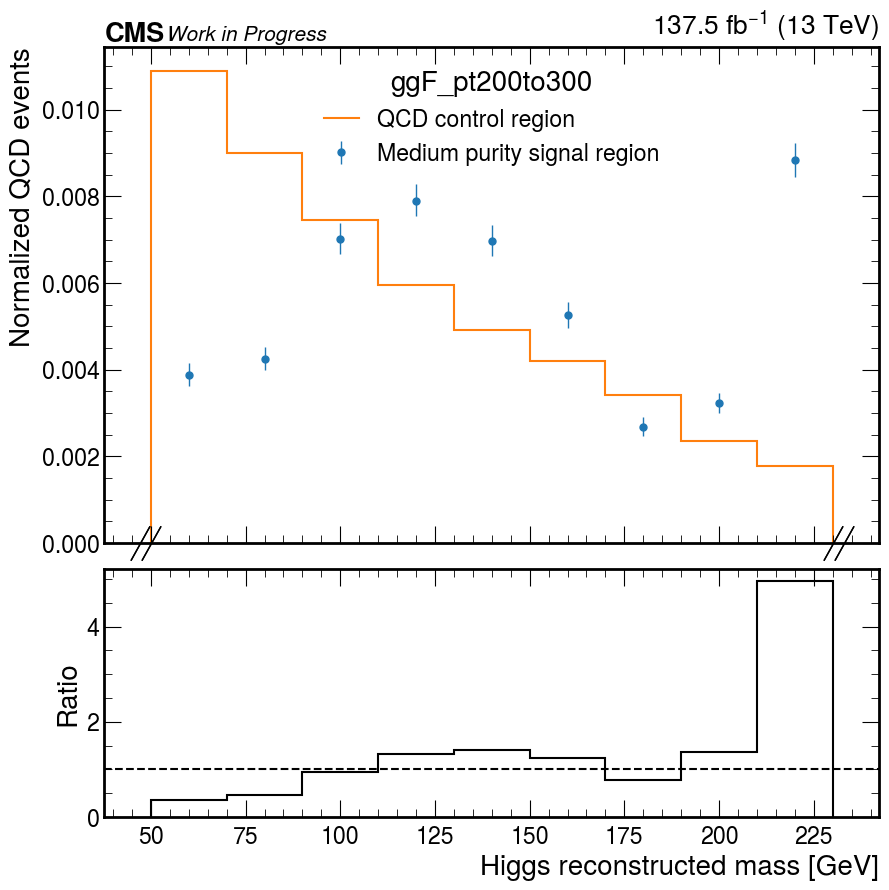

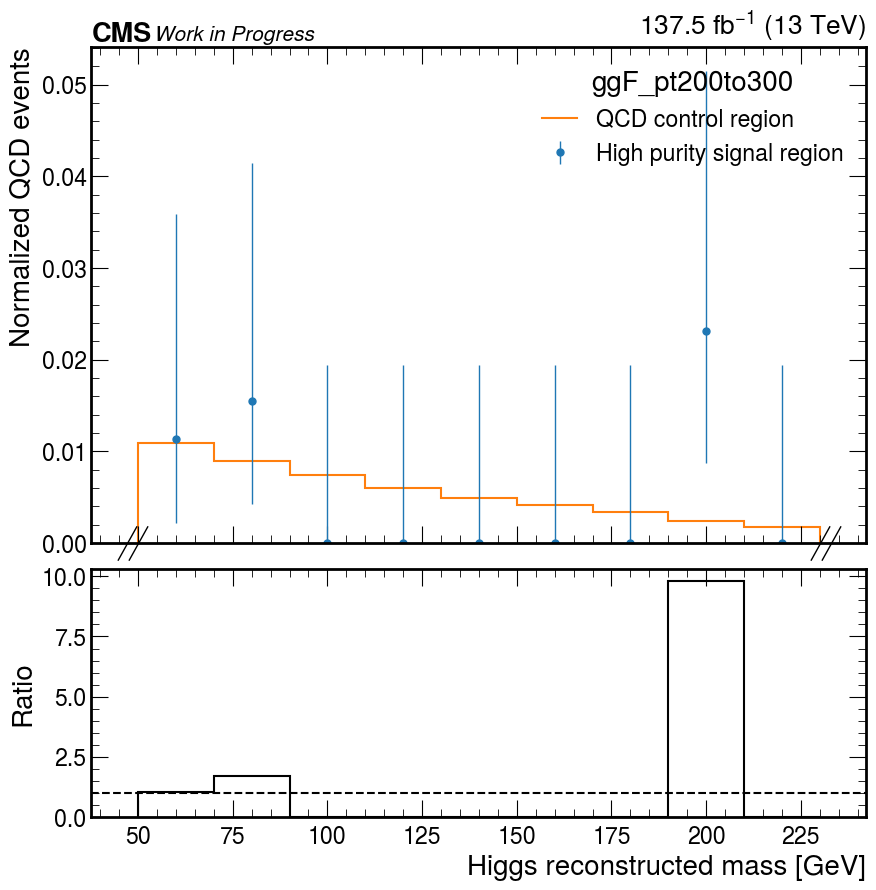

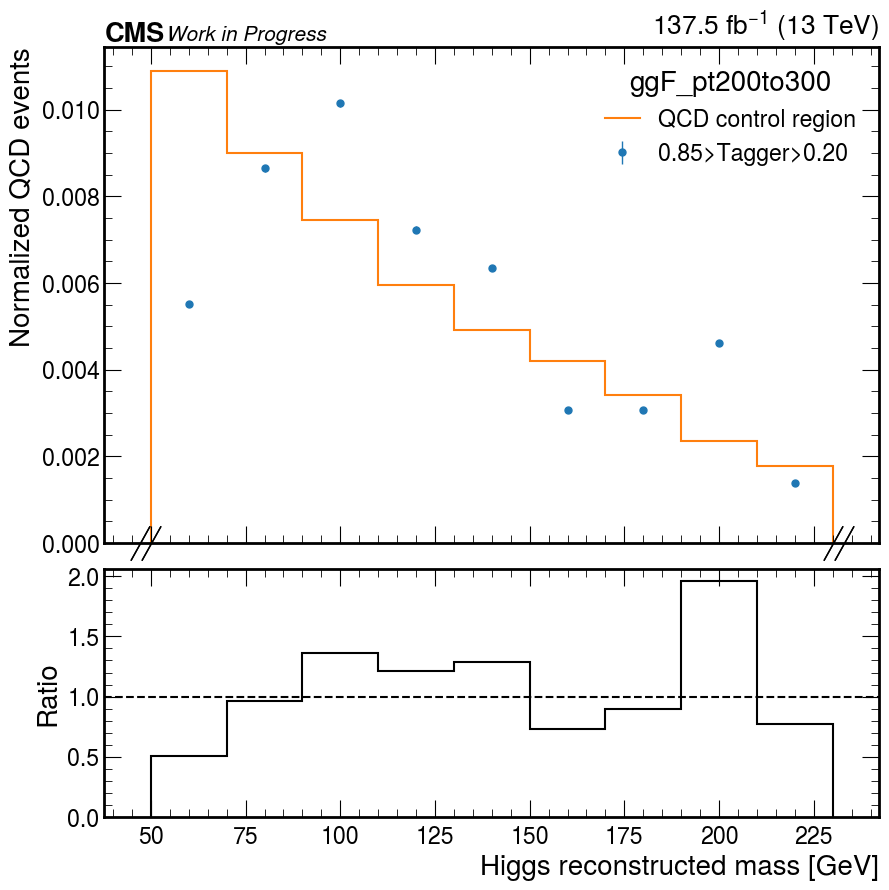

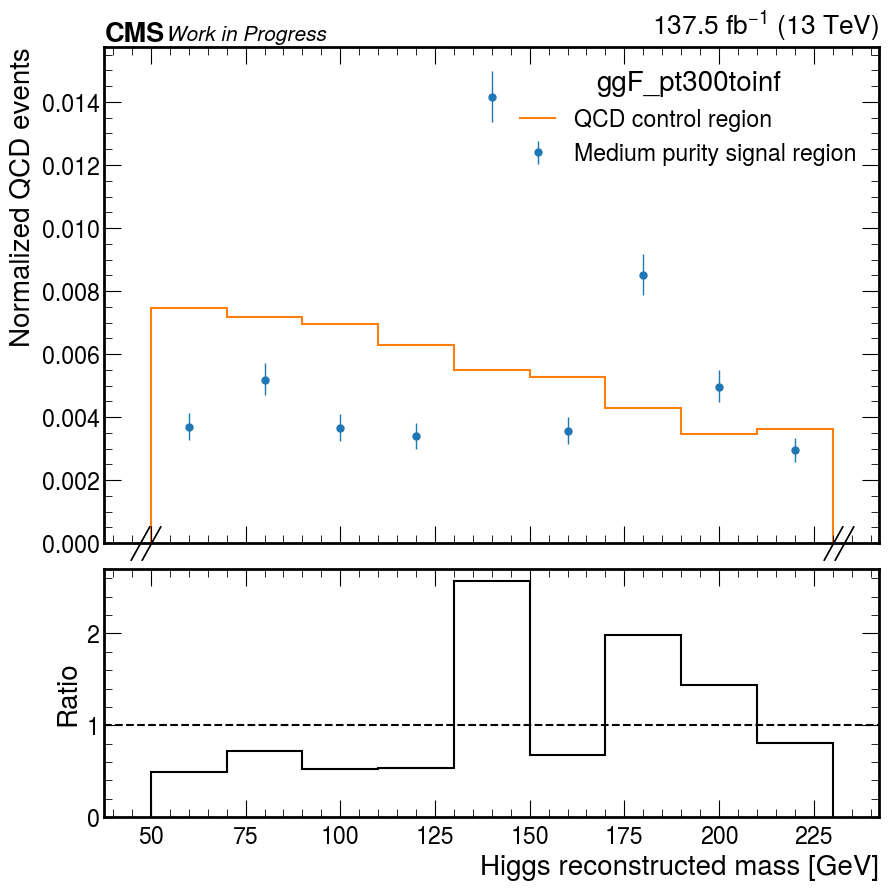

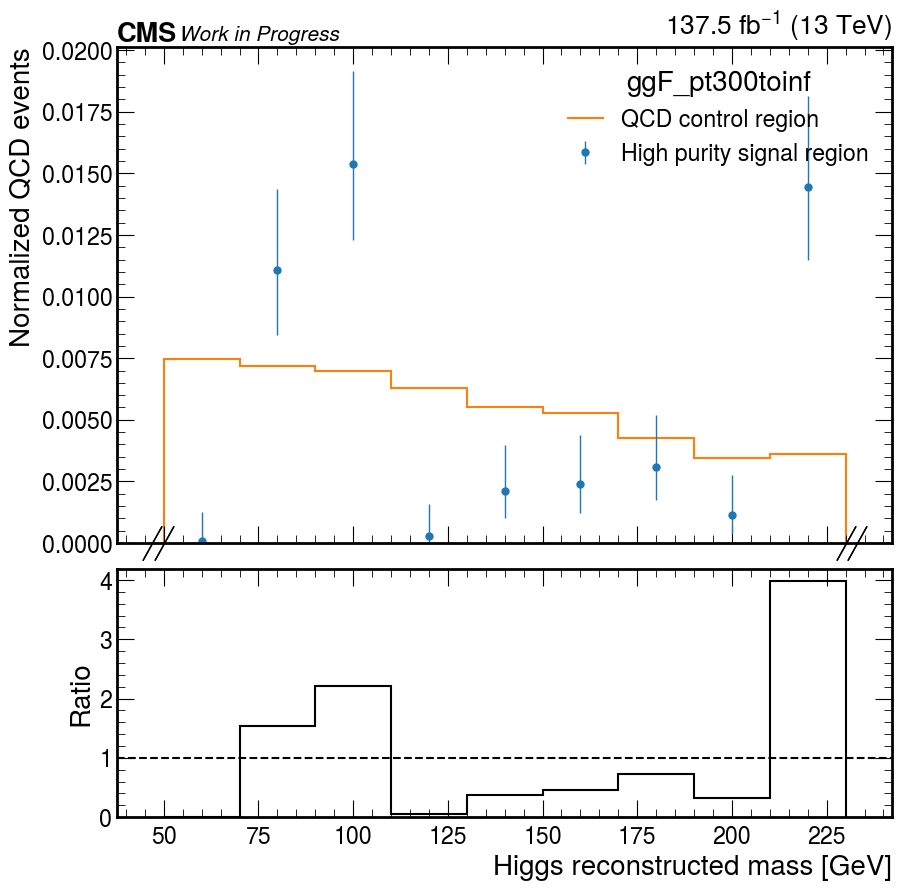

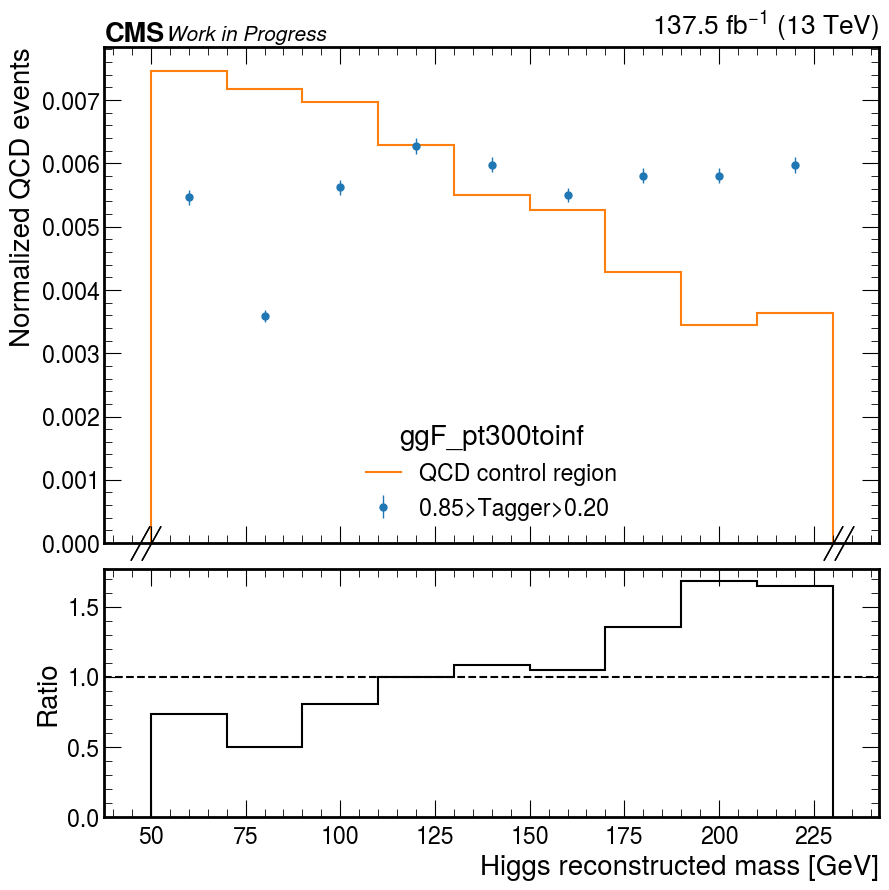

In [754]:
region_dic = {
    "Medium purity signal region": "medium",
    "High purity signal region": "high",
    "0.85>Tagger>0.20": "low",    
}

for category in ["VBF_pt200toinf", "ggF_pt200to300", "ggF_pt300toinf"]:
    
    for region in region_dic:
        plot_ratio(hists["rec_higgs_m"], 
                   years, 
                   region1 = region,
                   region2 = "QCD control region",
                   sample=sample,
                   category=category,
                   tag=f"{category}_{region_dic[region]}"
                  )

In [ ]:
fig, ax = plt.subplots(figsize=(14, 11))
ax.hist(
    x, 
    bins=np.linspace(50,300,bins), 
    weights=w,
    density=True, 
    histtype="step", 
    linewidth=2, 
    label=rf"{k} ($\mu$={np.mean(x):.1f}, $\sigma$={np.std(x):.1f})"
)

ax.axvline(125, color="grey", linestyle="--", label=rf"125 GeV")

if len(channels) > 1:
    ax.legend(title=f"{sample}")    
else:
    ax.legend(title=f"{nice_ch[ch]} channel - {sample}")


ax.set_ylabel("Events")
ax.set_xlabel(f"Reconstructed Higgs mass [GeV]")
ax.set_ylim(0)

lum_=0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku/mass_sculpting_{sample}.pdf")        

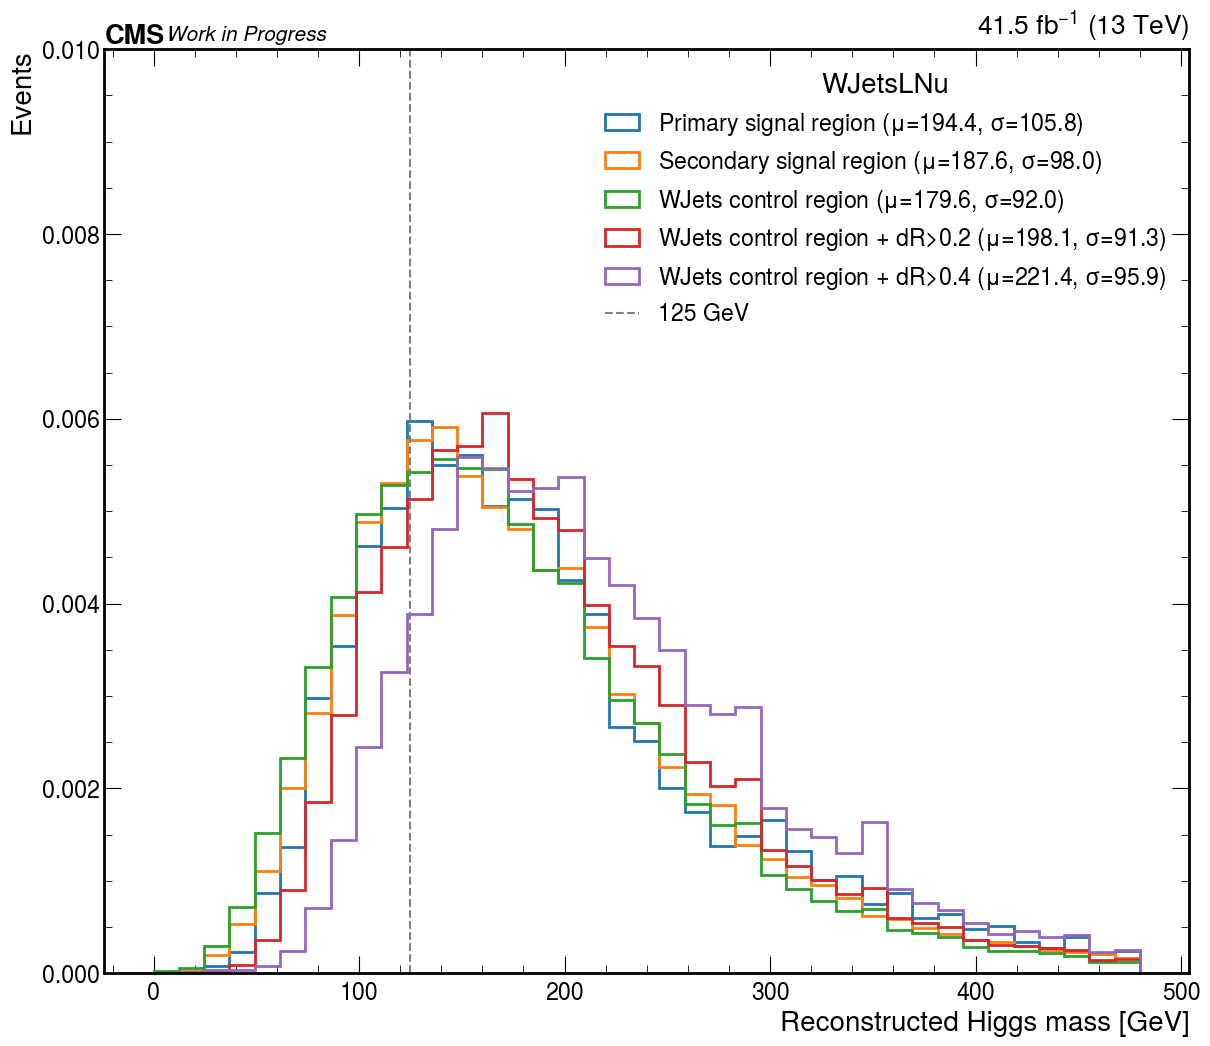

In [140]:
fig, ax = plt.subplots(figsize=(14, 12))
for region, sel in presel.items():

    df1 = df.copy().query(sel)

    x = df1["rec_higgs_m"]
    ax.hist(
        x, 
        bins=np.linspace(0,480,bins), 
        weights=df1["weight"],
        density=True, 
        histtype="step", 
        linewidth=2, 
        label=rf"{region} ($\mu$={np.mean(x):.1f}, $\sigma$={np.std(x):.1f})"
    )

ax.axvline(125, color="grey", linestyle="--", label=rf"125 GeV")

if len(channels) > 1:
    ax.legend(title=f"{sample}")    
else:
    ax.legend(title=f"{nice_ch[ch]} channel - {sample}")


ax.set_ylabel("Events")
ax.set_xlabel(f"Reconstructed Higgs mass [GeV]")
ax.set_ylim(0, 0.01)

luminosity = 0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    luminosity += lum / len(channels)    
        
hep.cms.lumitext("%.1f " % luminosity + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakiko/{sample}.pdf")  